# LSTM para previsão de casos do COVID-19

Aplicação da rede LSTM desenvolvida e disponibilizada por Luis Ricardo e Marcos Rodrigues.

O código foi organizado e aplicado como requisto para o trabalho de Matemática Computacional (CAP-239-4)

## Definição das funções do modelo


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# univariate data preparation
import numpy as np
from numpy import array
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM,Flatten
from keras import layers
from keras import models
from keras import optimizers
from keras.models import Sequential
from numpy import array 
from numpy import hstack 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math, pickle, csv, os

path = os.getcwd() # Diretório atual

Using TensorFlow backend.


In [2]:
def organizar_dados(path_input,tipo_analise,pais):
    path = os.path.join(path_input, tipo_analise)
    list_files_analise = os.listdir(path)
    list_files_analise.sort()
    serie_analise = pd.read_csv(os.path.join(path, list_files_analise[0]), 
                                  header = None, engine = 'python')
    select_analise = serie_analise[serie_analise[0] == pais]
    select_analise = select_analise[[0, 2, 3]]
    return select_analise


def split_sequences(sequences, n_steps_in, n_steps_out):
    '''
    Brownlee, J. (2018). Deep Learning for Time Series Forecasting: 
    Predict the Future with MLPs, CNNs and LSTMs in Python. 
    Machine Learning Mastery.
    '''
    X, y = list(), list() 
    for i in range(len(sequences)): 
        #find the end of this pattern 
        end_ix = i + n_steps_in 
        out_end_ix = end_ix + n_steps_out 
        #check if we are beyond the dataset 
        if out_end_ix > len(sequences): 
            break 
        #gather input and output parts of the pattern 
        seq_x, seq_y = sequences[i:end_ix], sequences[end_ix:out_end_ix] 
        X.append(seq_x) 
        y.append(seq_y) 
    return X, y

def preparar_dados(dados_covid, n_dias_entrada, n_dias_saida):    
    # choose a number of time steps 
    # covert into input/output
    dados_covid = dados_covid.iloc[:,2]
    dados_covid = np.float64(dados_covid.tolist())
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = dados_covid.reshape(-1, 1)
    data = scaler.fit_transform(data)
    data = data.reshape(len(data),)
    
    X, y = split_sequences(data, n_dias_entrada, n_dias_saida)
    
    inputarray = data[-n_dias_entrada:]
    inputarray = [float(i) for i in inputarray]
    inputarray = np.asarray(inputarray)

    X = np.float64(X)
    y = np.float64(y)    
    return data, X,y, inputarray,scaler


def definir_modelo_lstm_simples(modelo,n_dias_entrada, n_dias_saida):
    n_features = 1
    modelo.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_dias_entrada, n_features)))
    modelo.add(LSTM(200, activation='relu'))
    modelo.add(Dense(n_dias_saida))
    
    modelo.compile(optimizer='adam', loss='mse')
    return modelo

def treinamento(X,y,modelo,epocas,batch):
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    # fit model
    history = modelo.fit(X, y, epochs=epocas,batch_size=batch)

    return history

def predict(modelo,inputarray,n_dias_entrada):
    n_features = 1
    x_input = inputarray
    x_input = x_input.reshape((1, n_dias_entrada, n_features))
    yhat = modelo.predict(x_input, verbose=0)
    
    y_future = np.asarray(yhat)
    y_future = yhat.ravel()
    y_future = np.float64(y_future)
    return y_future

def validacao(modelo,n_dias_entrada,inputarray):
    n_features = 1
    x_input = inputarray
    x_input = x_input.reshape((1, n_dias_entrada, n_features))
    yhat = modelo.predict(x_input, verbose=0)
    
    y_future = np.asarray(yhat)
    y_future = yhat.ravel()
    y_future = np.float64(y_future)
    
    return y_future
   
def salvarmodelo(nome,modelo):
    #Salvando
    filename = nome+'.sav'
    pickle.dump(modelo, open(filename, 'wb'))
    

def salvardicionario(nome, history):
    #Salvando Dicionario
    w = csv.writer(open(nome+".csv", "w"))
    for key, val in history.items():
        w.writerow([key, val])    

def carregaModelo(nomeModelo):
    carrega_modelo = pickle.load(open(nomeModelo+'.sav', 'rb'))
    return carrega_modelo

**Função para treinamento automatizado**

In [3]:
def gerarTreinamento_parametros(pais,version,n_entradas,n_saidas, epochs = 50, batch = 1):
    #Parametros: (path_input,tipo_analise,pais)
    daily_cases = organizar_dados(str(os.getcwd()), "Number_Daily_Cases", pais)
    
    #Parametros: (dados_covid, n_dias_entrada, n_dias_saida) -- scaler - toback oringial data
    dados_covid, X,y, input_array, scaler = preparar_dados(daily_cases, n_entradas, n_saidas)
    
    ##Parametros: (modelo,n_dias_entrada, n_dias_saida)
    modelo = Sequential()
    modelo = definir_modelo_lstm_simples(modelo,n_entradas, n_saidas)
    
    #Parametros: (X,y,modelo,epocas,batch)
    history = treinamento(X, y, modelo, epochs, batch)
    #cria dicionario
    history = history.history
    history.keys()
    
    #Salvando Dicionario
    salvardicionario("History_" + pais + "_" + version, history)
    salvarmodelo("Modelo_" + pais + "_" + version, modelo)

**Função para validação**

In [4]:
def geraValidacao(pais, modelo, n_entrada, n_saida, plt_title = "RMSE: {rmse}"):
    daily_cases = organizar_dados(str(os.getcwd()), "Number_Daily_Cases", pais)
    dados_covid, X,y, input_array, scaler = preparar_dados(daily_cases, n_entrada, n_saida)
    
    #Carrega modelo já Treinado
    modelo = carregaModelo(modelo)
    
    list_pred = []
    for i in range(0, 130, n_saida):
        input_array_test =  np.array(dados_covid[i:(i+n_entrada)])
        if len(input_array_test) < n_entrada:
           input_array_test = np.append(input_array_test,[0],axis = None)
        y_predict_val_test = predict(modelo,input_array_test,n_entrada)
        list_pred.append(y_predict_val_test)
    
    plt.figure()
    concatenado = np.concatenate((list_pred[:]))
    true = dados_covid[n_entrada:len(concatenado)+n_entrada]

    if len(true) < len(concatenado):
        print("entrou condi")
        lim = (len(concatenado) - len(true))
        concatenado = concatenado[0:len(concatenado) - lim]
        
    score_rmse = math.sqrt(mean_squared_error(concatenado, true))
    plt.figure(dpi = 150)
    plt.plot(concatenado,'r--', label = 'Valores preditos')
    plt.plot(true,'b',label = 'Valores reais')
    plt.xlabel('Dias')
    plt.ylabel('Casos diários')
    plt.legend(loc ='upper right')
    plt.title(plt_title.format(rmse = str(round(score_rmse, 4))))
    # plt.title('RMSE: %.4f' % (score_rmse))
    
    return score_rmse

In [5]:
os.makedirs('Number_Daily_Cases', exist_ok = True)

# Funções auxiliares

Esta seção apresenta funções auxiliares para múltiplas execuções. Criado para os testes do trabalho da disciplina de Matemática Computacional (CAP-239-4)

In [6]:
def multiplas_execucoes(pais, padroes_de_entrada, plt_title, epochs_range = None, **kwargs):
  import warnings
  class EpochsChange(RuntimeWarning): ...
  
  def treina_modelo(pais, padroes_de_entrada, plt_title, **kwargs):
    VERSAOT = "v{num}"
    results = {
      'nome_modelo': [],
      'versao': [],
      'entradas': [],
      'rmse': [],
      'epoch': []
    }
    
    for padrao_de_entrada, num in zip(padroes_de_entrada, range(len(padroes_de_entrada))):
      versaot = VERSAOT.format(num = num)
      nmodelo = f"Modelo_{pais}_{versaot}"
      print(nmodelo)

      gerarTreinamento_parametros(pais, versaot, *padrao_de_entrada, **kwargs)
      results['nome_modelo'].append(nmodelo)
      results['versao'].append(versaot)
      results['entradas'].append(padrao_de_entrada)
      
      if kwargs['epochs']:
        results['epoch'].append(kwargs['epochs'])
      else:
        results['epoch'].append(50) # Padrão de épocas

      results['rmse'].append(
          geraValidacao(pais, nmodelo, *padrao_de_entrada, plt_title = plt_title)
      )
    return pd.DataFrame(results)

  if not epochs_range:
    return treina_modelo(pais, padroes_de_entrada, plt_title, **kwargs)
  else:
    warnings.warn("O programa está sendo executado no modo de múltiplas épocas", EpochsChange)

    res = []
    for i in range(*epochs_range):
      res.append(treina_modelo(pais, padroes_de_entrada, plt_title, epochs = i))
    return pd.concat(res)
  raise RuntimeError("Os parâmetros inseridos são inválidos")

# Organização dos dados

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
df = df[~df.new_cases.isna()]

**Organizando os dados**

Abaixo, os dados são organizados para o formato utilizado no código de LSTM desenvolvido e disponibilizado pelo Luis Ricardo e Marcos Rodrigues

> A estrutura dos dados é organizada e salva em um arquivo, da mesma forma como definido no programa original

In [9]:
serie_cases = df[['location', 'iso_code', 'date', 'new_cases']]
serie_cases.columns = [0, 1, 2, 3]

serie_cases.to_csv("Number_Daily_Cases/daily-cases-covid-19.csv", index = False)

# Execução do modelo

**Predizendo valores para um país**

In [10]:
gerarTreinamento_parametros("Italy", "v1", 20, 10, epochs = 5)

Epoch 1/5
141/141 [==============================] - 5s 34ms/step - loss: 0.0500
Epoch 2/5
141/141 [==============================] - 4s 30ms/step - loss: 0.0262
Epoch 3/5
141/141 [==============================] - 4s 29ms/step - loss: 0.0167
Epoch 4/5
141/141 [==============================] - 4s 29ms/step - loss: 0.0117
Epoch 5/5
141/141 [==============================] - 4s 29ms/step - loss: 0.0088


<Figure size 432x288 with 0 Axes>

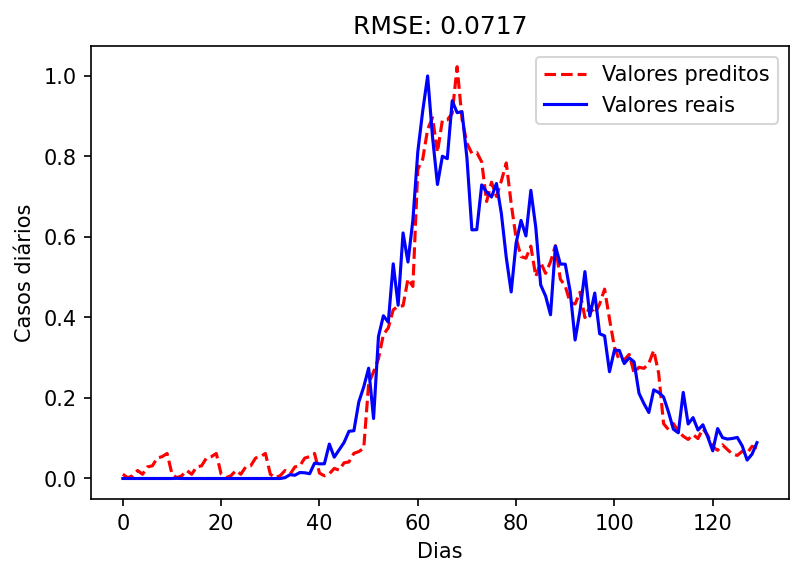

In [11]:
# pontos de entrada
n_entrada = 20
# pontos de saida
n_saida = 10
score_portugal_1 = geraValidacao("Italy", "Modelo_Italy_v1", n_entrada, n_saida)

# Múltiplas execuções

Nesta seção, múltiplas execuções são feitas para teste dos parâmetros.

## Epoch único

**Canadá**

Modelo_Canada_v0
Epoch 1/2
143/143 [==============================] - 6s 40ms/step - loss: 0.0261
Epoch 2/2
143/143 [==============================] - 5s 35ms/step - loss: 0.0137
Modelo_Canada_v1
Epoch 1/2
134/134 [==============================] - 6s 44ms/step - loss: 0.0512
Epoch 2/2
134/134 [==============================] - 5s 38ms/step - loss: 0.0190
Modelo_Canada_v2
Epoch 1/2
141/141 [==============================] - 5s 37ms/step - loss: 0.0364
Epoch 2/2
141/141 [==============================] - 4s 31ms/step - loss: 0.0190
Modelo_Canada_v3
Epoch 1/2
153/153 [==============================] - 4s 28ms/step - loss: 0.0238
Epoch 2/2
153/153 [==============================] - 4s 24ms/step - loss: 0.0127


<Figure size 432x288 with 0 Axes>

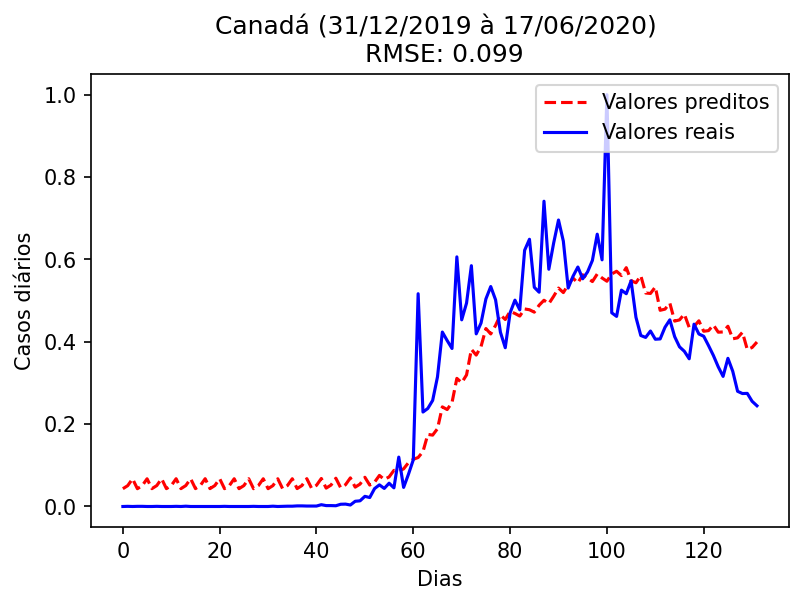

<Figure size 432x288 with 0 Axes>

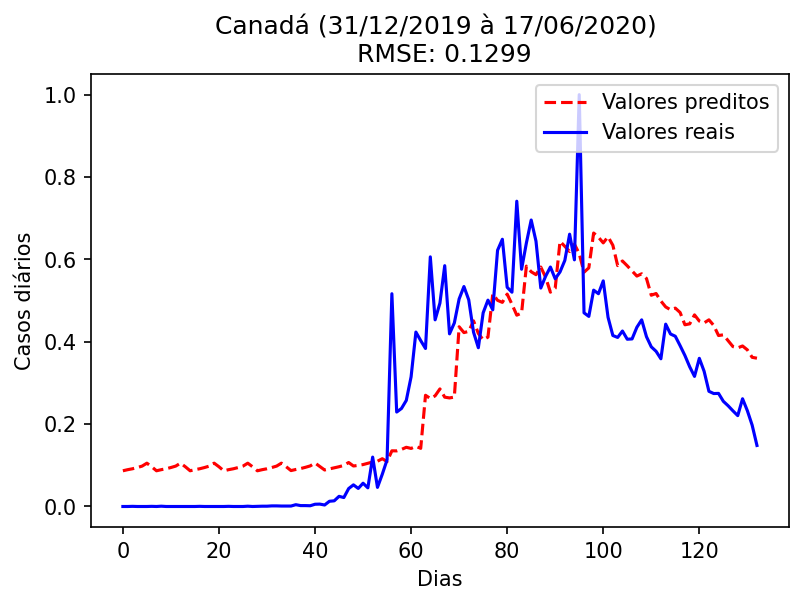

<Figure size 432x288 with 0 Axes>

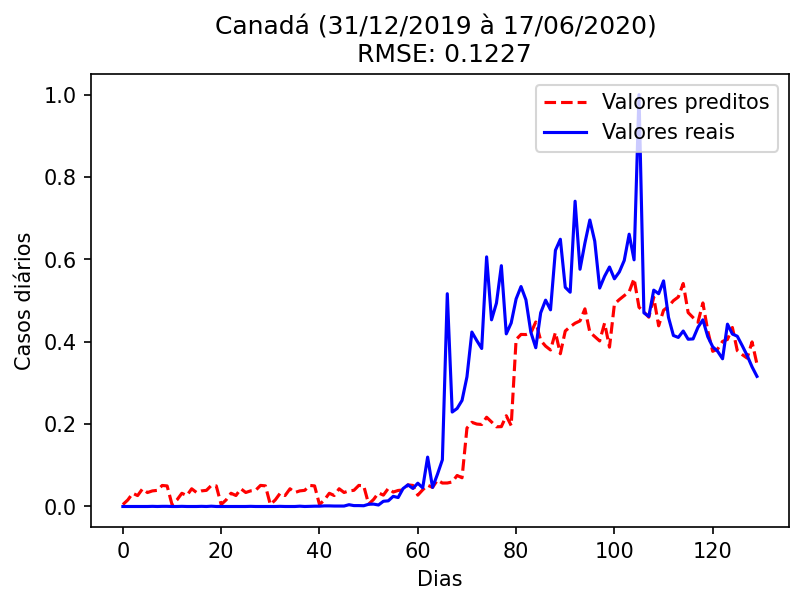

<Figure size 432x288 with 0 Axes>

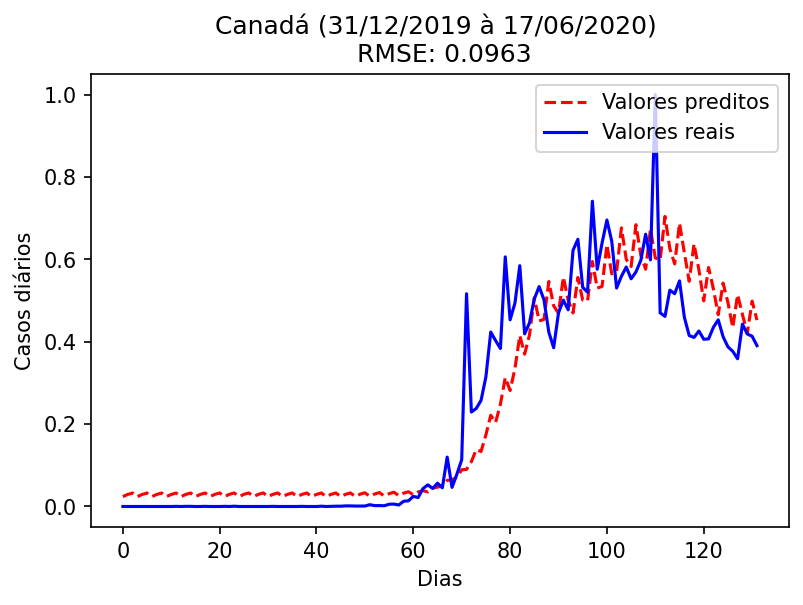

In [12]:
can_params = multiplas_execucoes("Canada", [(25, 3), (30, 7), (20, 10), (15, 3)], "Canadá (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", epochs = 2)

**Cuba**

In [13]:
# cub_params = multiplas_execucoes("Cuba", [(10, 2)], "Cuba (I à F) \n {rmse}", epochs = 2)

**México**

Modelo_Mexico_v0
Epoch 1/2
135/135 [==============================] - 5s 40ms/step - loss: 0.0202
Epoch 2/2
135/135 [==============================] - 5s 35ms/step - loss: 0.0052
Modelo_Mexico_v1
Epoch 1/2
126/126 [==============================] - 6s 46ms/step - loss: 0.0427
Epoch 2/2
126/126 [==============================] - 5s 41ms/step - loss: 0.0082
entrou condi
Modelo_Mexico_v2
Epoch 1/2
133/133 [==============================] - 5s 38ms/step - loss: 0.0387
Epoch 2/2
133/133 [==============================] - 4s 30ms/step - loss: 0.0038
Modelo_Mexico_v3
Epoch 1/2
145/145 [==============================] - 4s 27ms/step - loss: 0.0264
Epoch 2/2
145/145 [==============================] - 3s 23ms/step - loss: 0.0039


<Figure size 432x288 with 0 Axes>

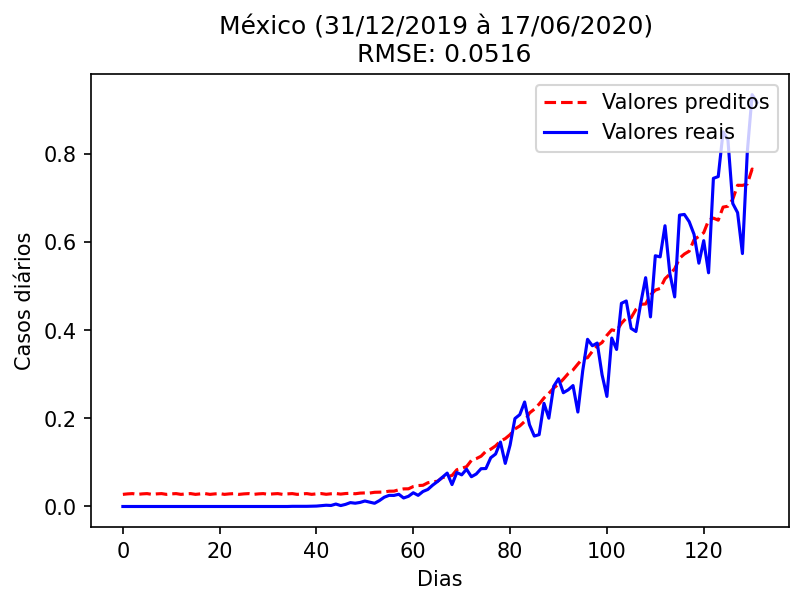

<Figure size 432x288 with 0 Axes>

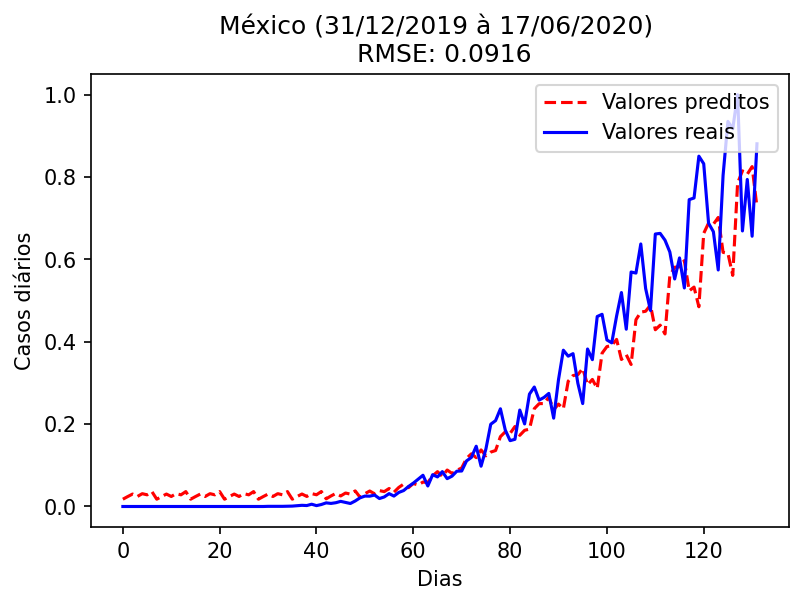

<Figure size 432x288 with 0 Axes>

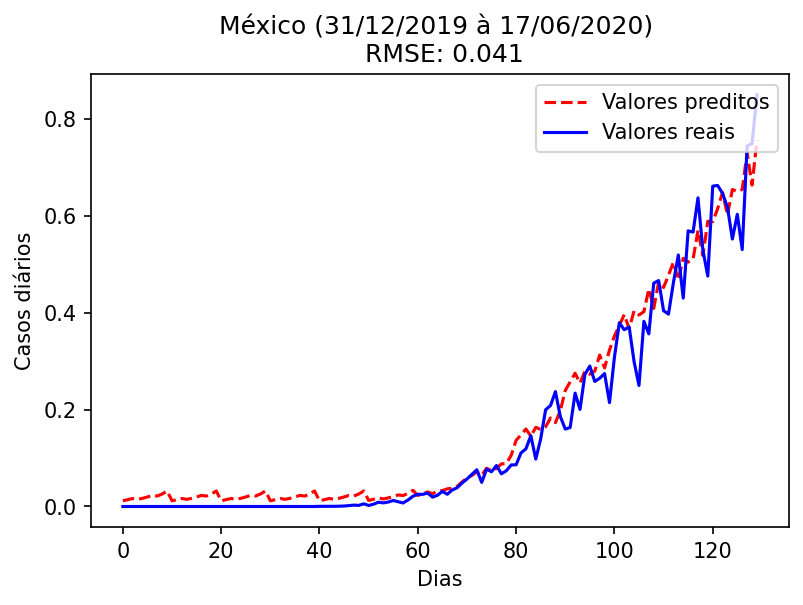

<Figure size 432x288 with 0 Axes>

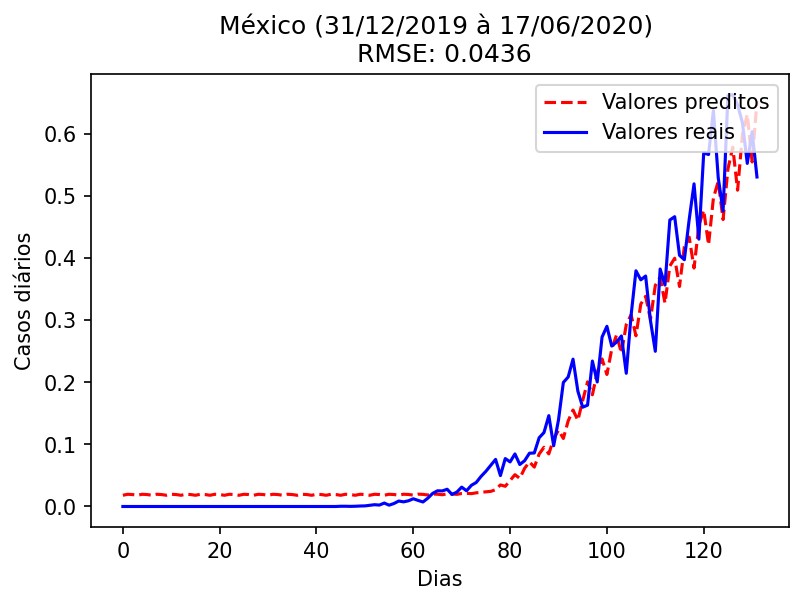

In [14]:
mex_params = multiplas_execucoes("Mexico", [(25, 3), (30, 7), (20, 10), (15, 3)], "México (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", epochs = 2)

**Rússia**

Modelo_Russia_v0
Epoch 1/2
143/143 [==============================] - 6s 39ms/step - loss: 0.0441
Epoch 2/2
143/143 [==============================] - 5s 35ms/step - loss: 0.0115
Modelo_Russia_v1
Epoch 1/2
134/134 [==============================] - 6s 44ms/step - loss: 0.1290
Epoch 2/2
134/134 [==============================] - 5s 40ms/step - loss: 4.0158
Modelo_Russia_v2
Epoch 1/2
141/141 [==============================] - 5s 34ms/step - loss: 0.4743
Epoch 2/2
141/141 [==============================] - 4s 29ms/step - loss: 0.0520
Modelo_Russia_v3
Epoch 1/2
153/153 [==============================] - 4s 26ms/step - loss: 0.0484
Epoch 2/2
153/153 [==============================] - 3s 23ms/step - loss: 0.0107


<Figure size 432x288 with 0 Axes>

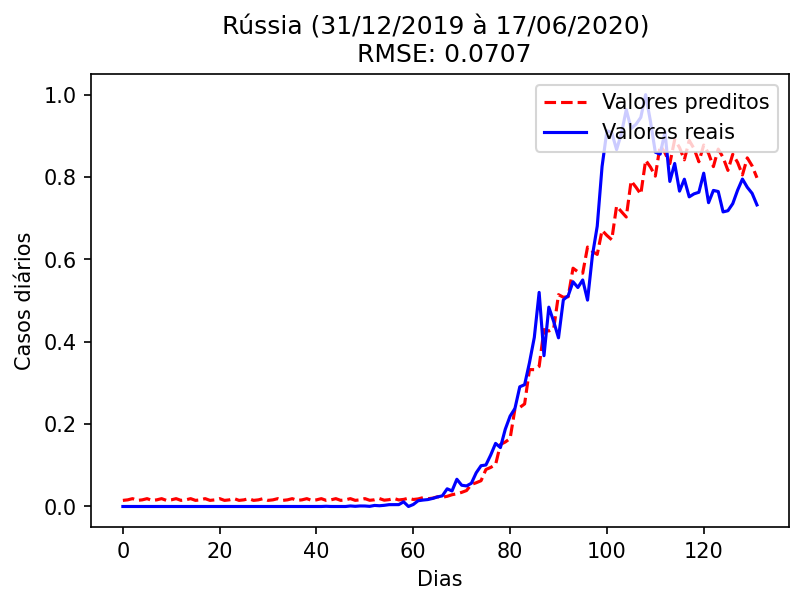

<Figure size 432x288 with 0 Axes>

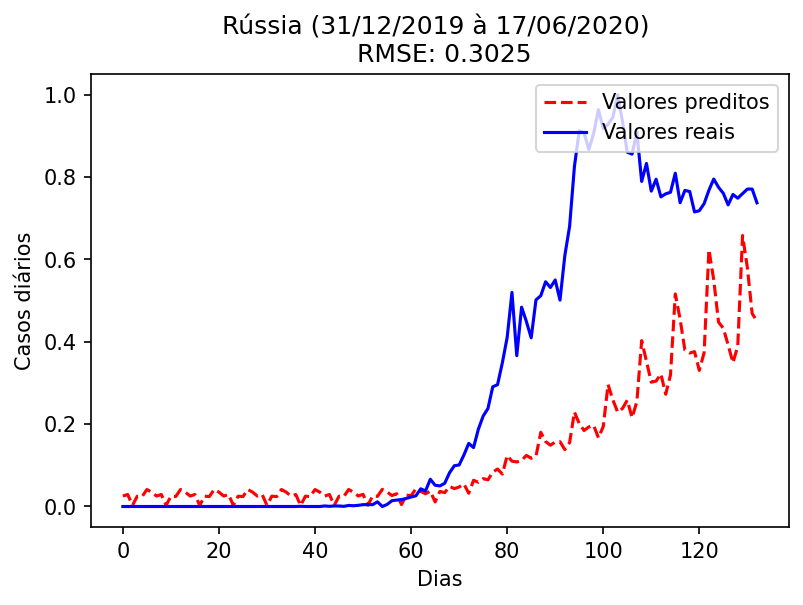

<Figure size 432x288 with 0 Axes>

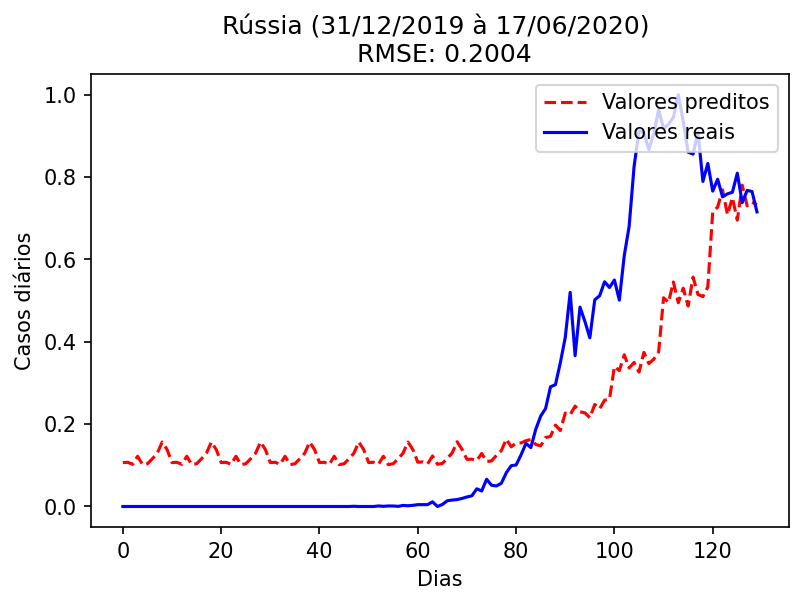

<Figure size 432x288 with 0 Axes>

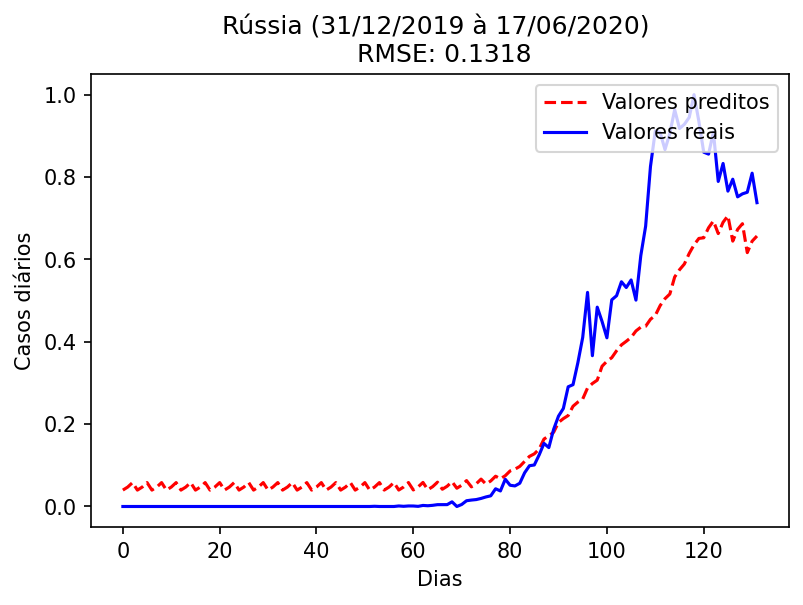

In [15]:
rus_params = multiplas_execucoes("Russia", [(25, 3), (30, 7), (20, 10), (15, 3)], "Rússia (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", epochs = 2)

**Brasil**

Modelo_Brazil_v0
Epoch 1/2
143/143 [==============================] - 6s 40ms/step - loss: 0.0294
Epoch 2/2
143/143 [==============================] - 5s 36ms/step - loss: 0.0138
Modelo_Brazil_v1
Epoch 1/2
134/134 [==============================] - 6s 46ms/step - loss: 0.0310
Epoch 2/2
134/134 [==============================] - 5s 40ms/step - loss: 0.0248
Modelo_Brazil_v2
Epoch 1/2
141/141 [==============================] - 5s 33ms/step - loss: 0.0516
Epoch 2/2
141/141 [==============================] - 7s 50ms/step - loss: 0.0418
Modelo_Brazil_v3
Epoch 1/2
153/153 [==============================] - 4s 26ms/step - loss: 0.0311
Epoch 2/2
153/153 [==============================] - 4s 23ms/step - loss: 0.0127


<Figure size 432x288 with 0 Axes>

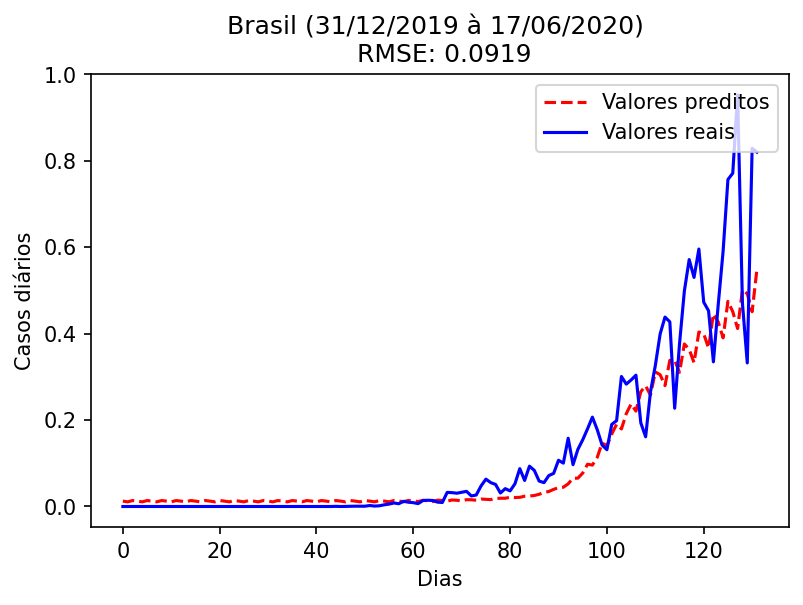

<Figure size 432x288 with 0 Axes>

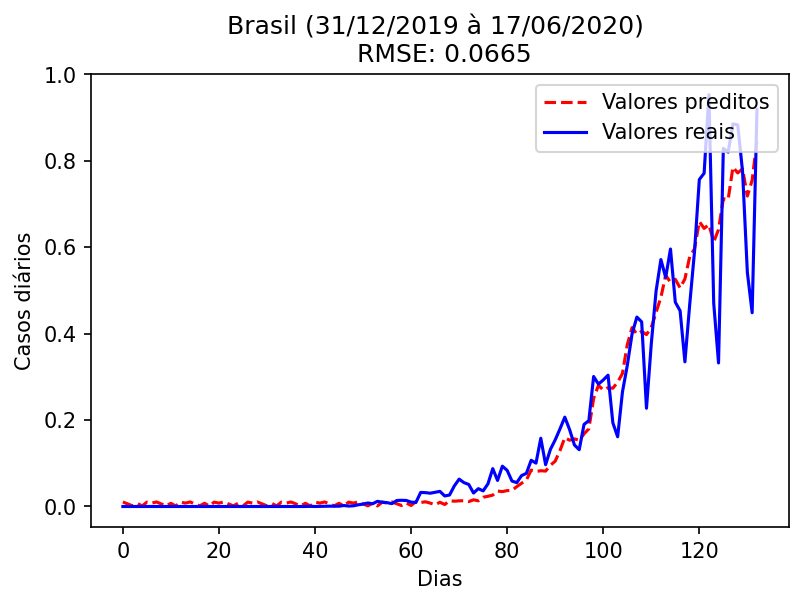

<Figure size 432x288 with 0 Axes>

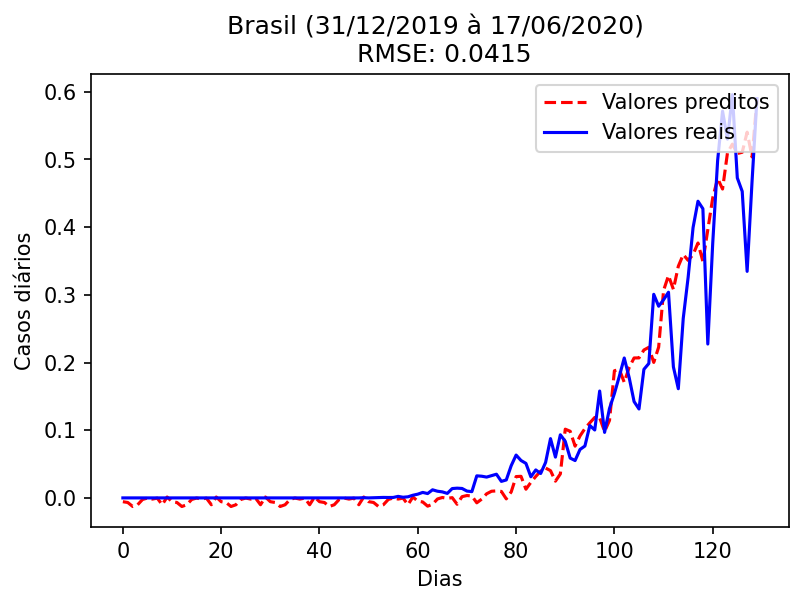

<Figure size 432x288 with 0 Axes>

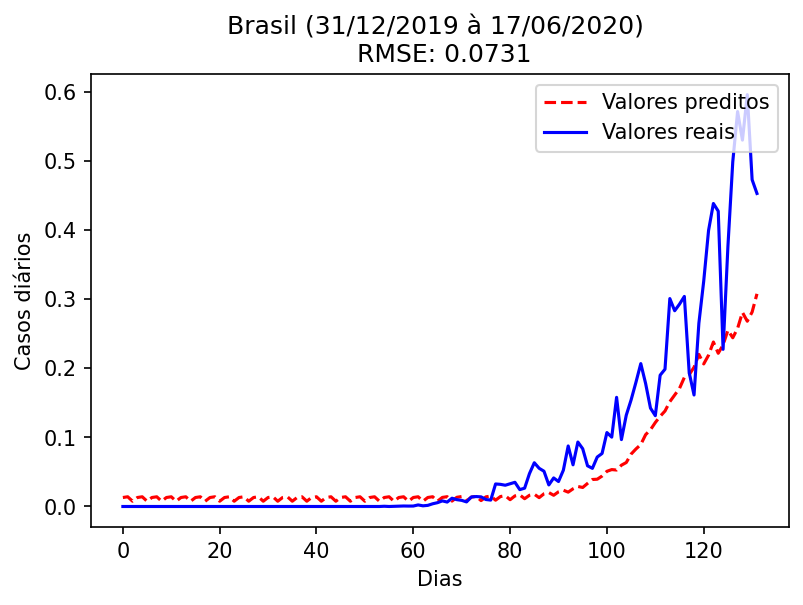

In [16]:
bras_params = multiplas_execucoes("Brazil", [(25, 3), (30, 7), (20, 10), (15, 3)], "Brasil (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", epochs = 2)

## Epoch múltiplos

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: EpochsChange: O programa está sendo executado no modo de múltiplas épocas


Modelo_Canada_v0
Epoch 1/2
143/143 [==============================] - 6s 40ms/step - loss: 0.0326
Epoch 2/2
143/143 [==============================] - 5s 35ms/step - loss: 0.0141
Modelo_Canada_v1
Epoch 1/2
134/134 [==============================] - 6s 46ms/step - loss: 0.0434
Epoch 2/2
134/134 [==============================] - 5s 41ms/step - loss: 0.0212
Modelo_Canada_v2
Epoch 1/2
141/141 [==============================] - 5s 34ms/step - loss: 0.0395
Epoch 2/2
141/141 [==============================] - 4s 31ms/step - loss: 0.0202
Modelo_Canada_v3
Epoch 1/2
153/153 [==============================] - 4s 26ms/step - loss: 0.0219
Epoch 2/2
153/153 [==============================] - 3s 22ms/step - loss: 0.0119
Modelo_Canada_v0
Epoch 1/3
143/143 [==============================] - 6s 40ms/step - loss: 0.0275
Epoch 2/3
143/143 [==============================] - 5s 35ms/step - loss: 0.0138
Epoch 3/3
143/143 [==============================] - 5s 35ms/step - loss: 0.0110
Modelo_Canada_v1
Epoch 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Modelo_Canada_v3
Epoch 1/4
153/153 [==============================] - 4s 25ms/step - loss: 0.0249
Epoch 2/4
153/153 [==============================] - 3s 22ms/step - loss: 0.0124
Epoch 3/4
153/153 [==============================] - 3s 22ms/step - loss: 0.0100
Epoch 4/4
153/153 [==============================] - 3s 22ms/step - loss: 0.0096


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

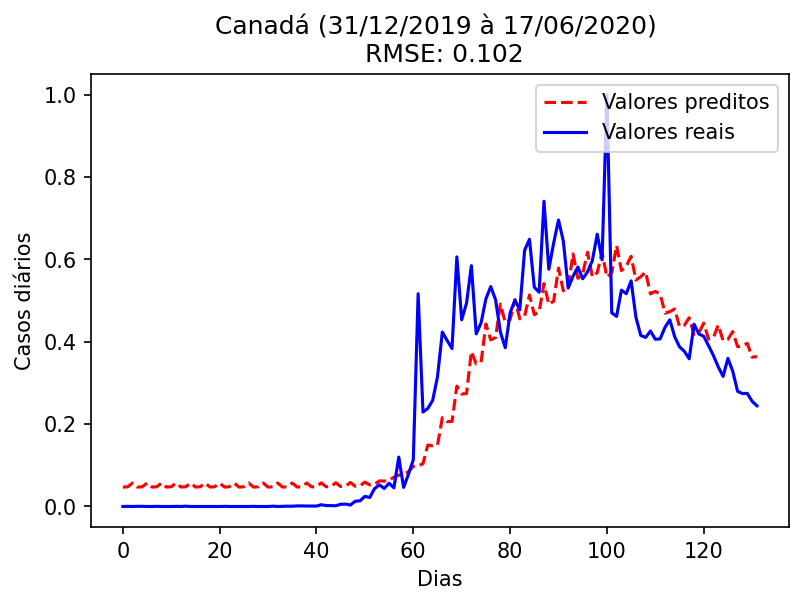

<Figure size 432x288 with 0 Axes>

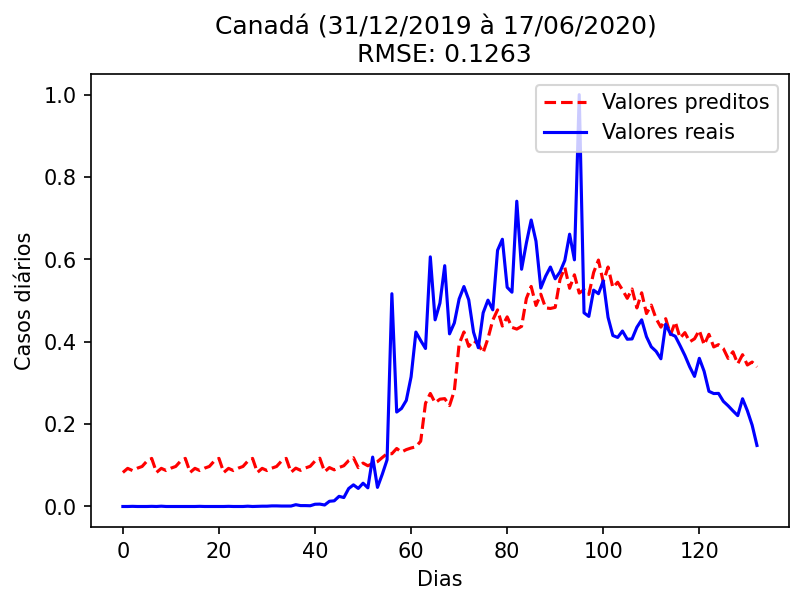

<Figure size 432x288 with 0 Axes>

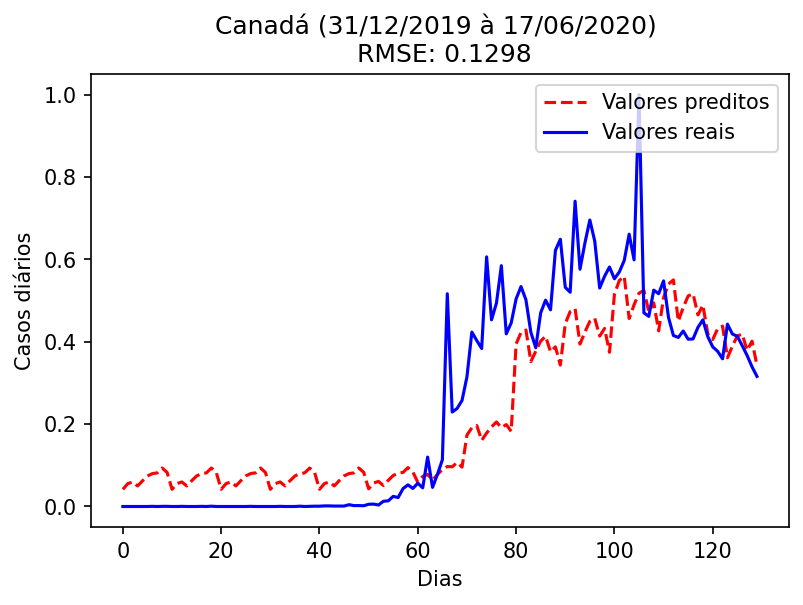

<Figure size 432x288 with 0 Axes>

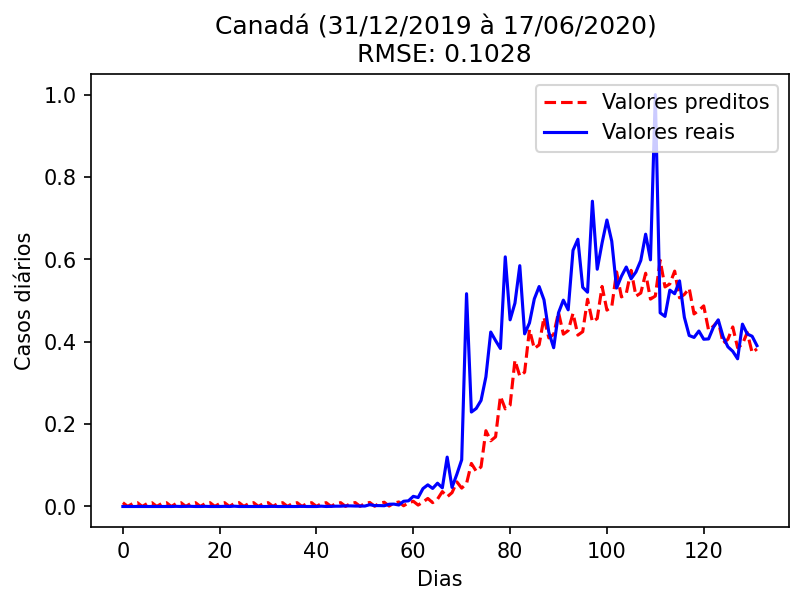

<Figure size 432x288 with 0 Axes>

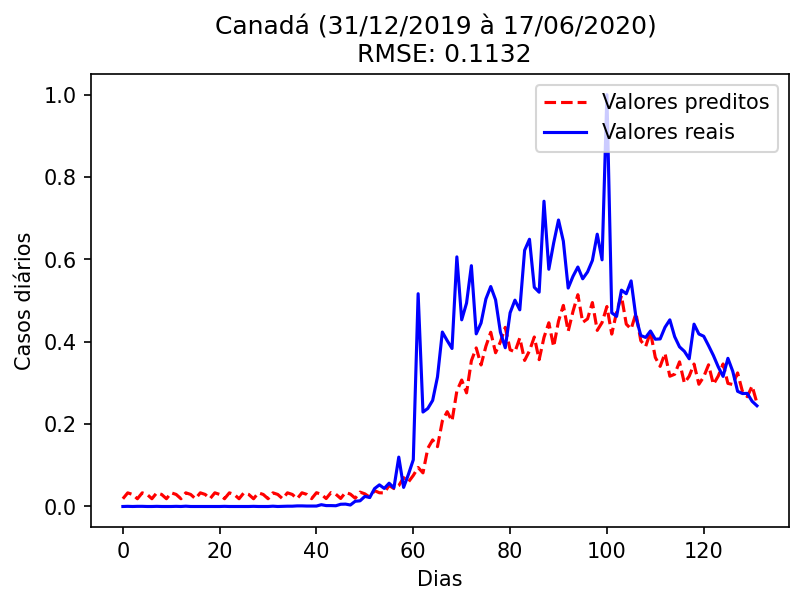

<Figure size 432x288 with 0 Axes>

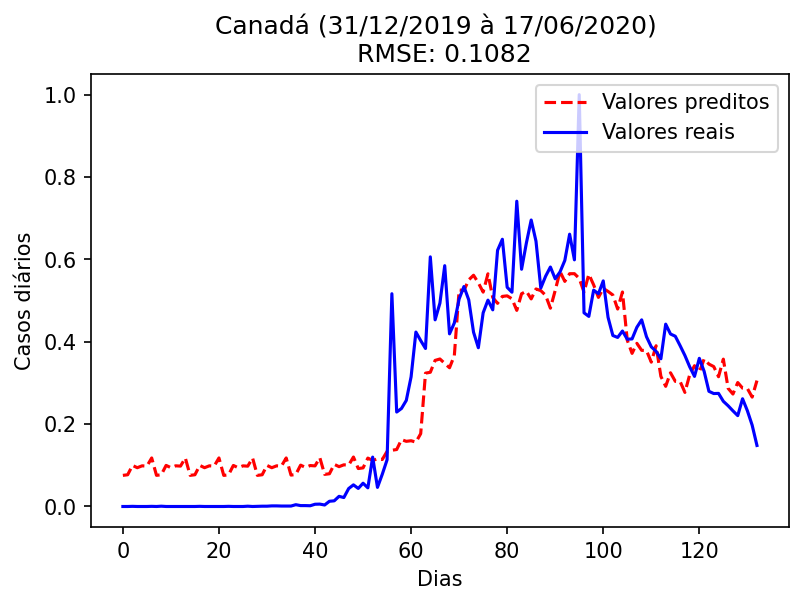

<Figure size 432x288 with 0 Axes>

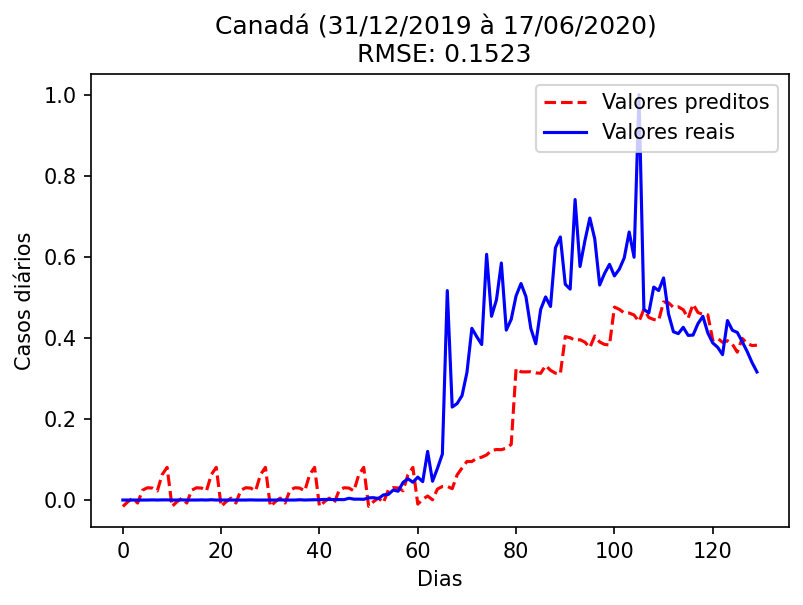

<Figure size 432x288 with 0 Axes>

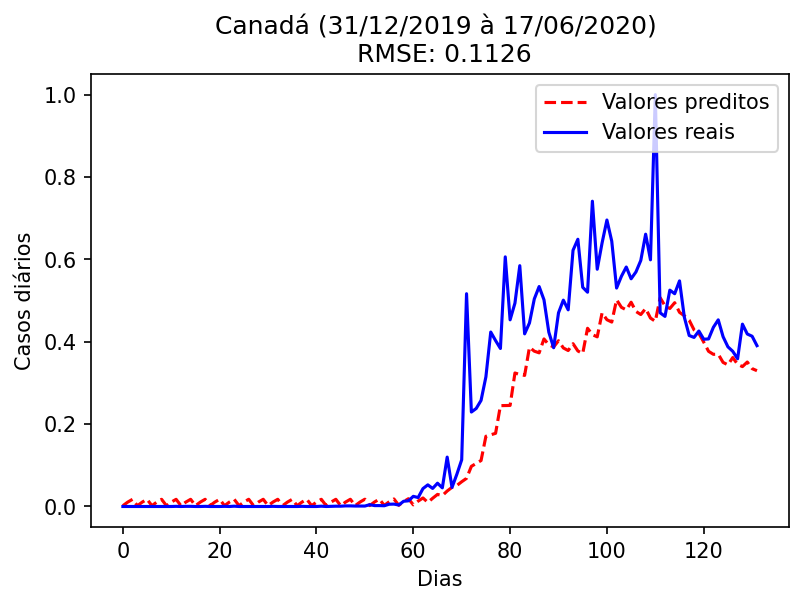

<Figure size 432x288 with 0 Axes>

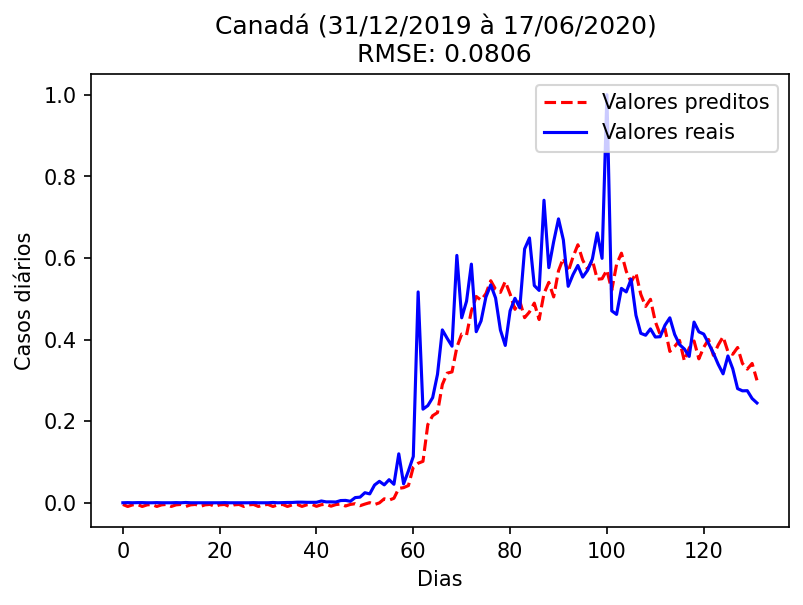

<Figure size 432x288 with 0 Axes>

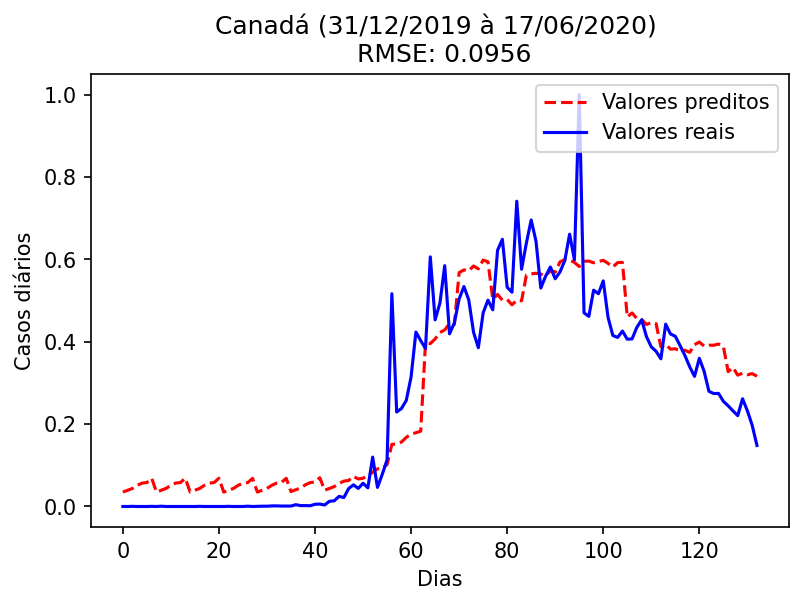

<Figure size 432x288 with 0 Axes>

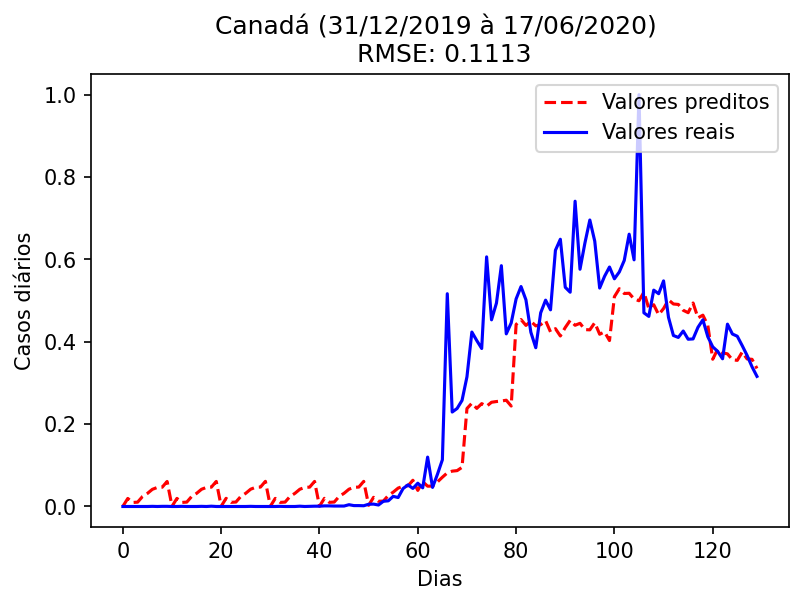

<Figure size 432x288 with 0 Axes>

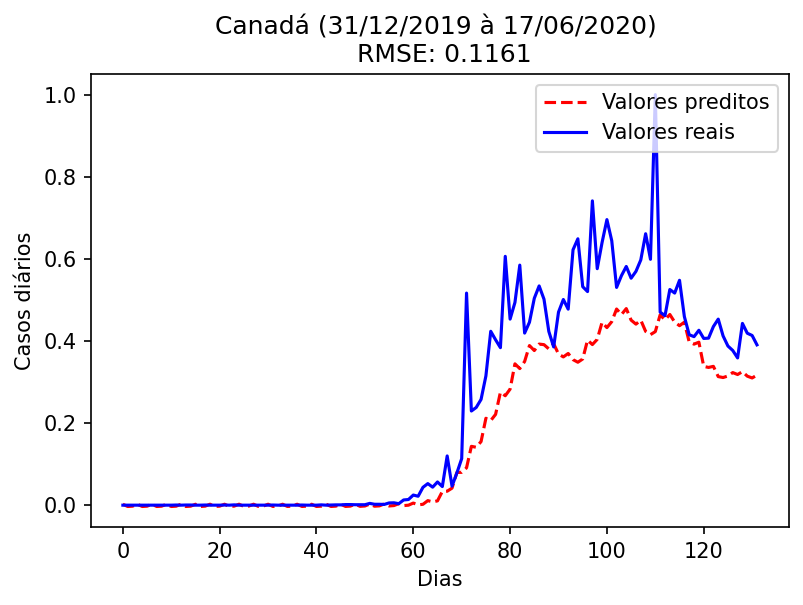

In [17]:
can_paramsrange = multiplas_execucoes("Canada", [(25, 3), (30, 7), (20, 10), (15, 3)],
                                      "Canadá (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", 
                                      epochs_range = (2, 5))

**Canadá**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: EpochsChange: O programa está sendo executado no modo de múltiplas épocas


Modelo_Canada_v0
Epoch 1/2
143/143 [==============================] - 5s 37ms/step - loss: 0.0389
Epoch 2/2
143/143 [==============================] - 5s 34ms/step - loss: 0.0139
Modelo_Canada_v1
Epoch 1/2
134/134 [==============================] - 6s 42ms/step - loss: 0.0374
Epoch 2/2
134/134 [==============================] - 5s 38ms/step - loss: 0.0163
Modelo_Canada_v2
Epoch 1/2
141/141 [==============================] - 4s 32ms/step - loss: 0.0358
Epoch 2/2
141/141 [==============================] - 4s 28ms/step - loss: 0.0200
Modelo_Canada_v3
Epoch 1/2
153/153 [==============================] - 4s 24ms/step - loss: 0.0223
Epoch 2/2
153/153 [==============================] - 3s 21ms/step - loss: 0.0132
Modelo_Canada_v0
Epoch 1/3
143/143 [==============================] - 5s 37ms/step - loss: 0.0329
Epoch 2/3
143/143 [==============================] - 5s 32ms/step - loss: 0.0127
Epoch 3/3
143/143 [==============================] - 5s 32ms/step - loss: 0.0089
Modelo_Canada_v1
Epoch 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Modelo_Canada_v3
Epoch 1/4
153/153 [==============================] - 4s 24ms/step - loss: 0.0225
Epoch 2/4
153/153 [==============================] - 3s 20ms/step - loss: 0.0116
Epoch 3/4
153/153 [==============================] - 3s 20ms/step - loss: 0.0110
Epoch 4/4
153/153 [==============================] - 3s 21ms/step - loss: 0.0088


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

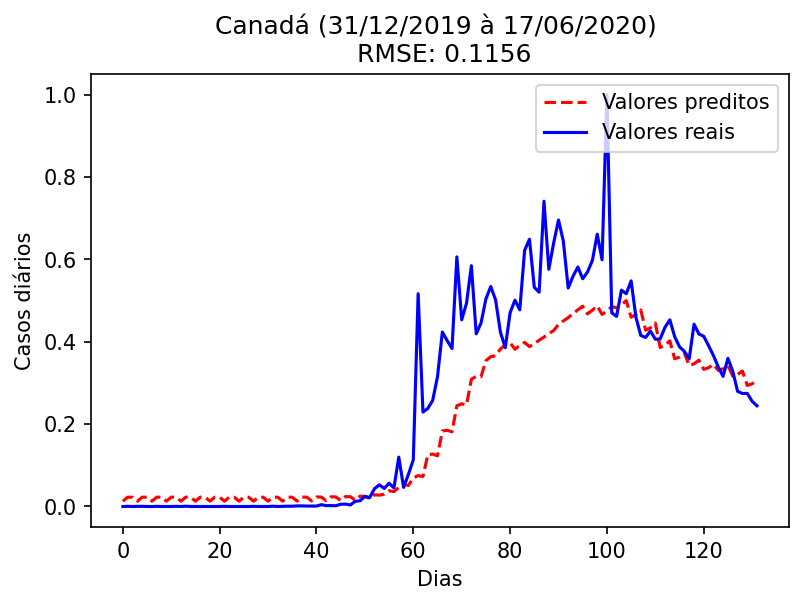

<Figure size 432x288 with 0 Axes>

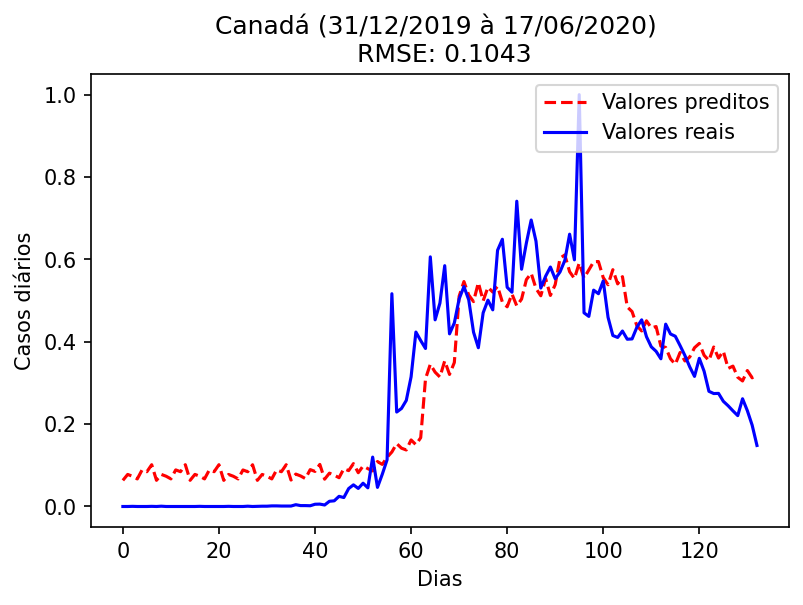

<Figure size 432x288 with 0 Axes>

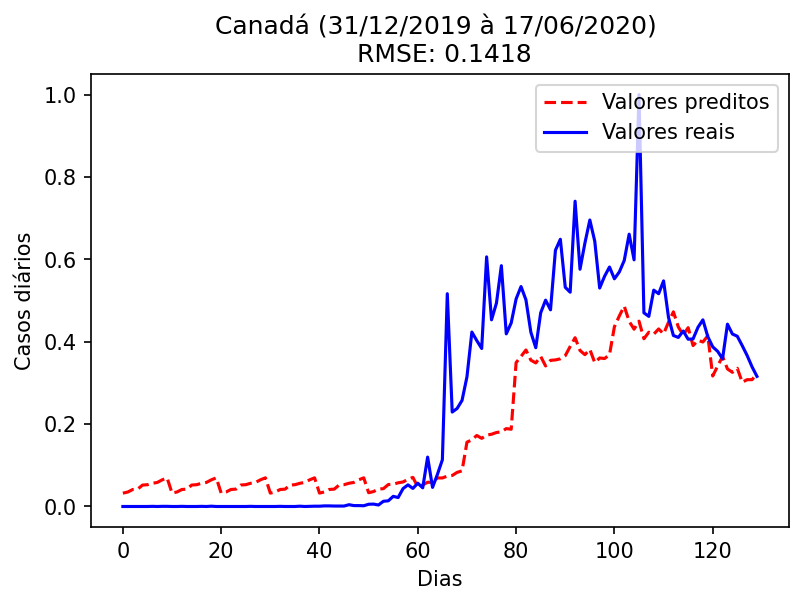

<Figure size 432x288 with 0 Axes>

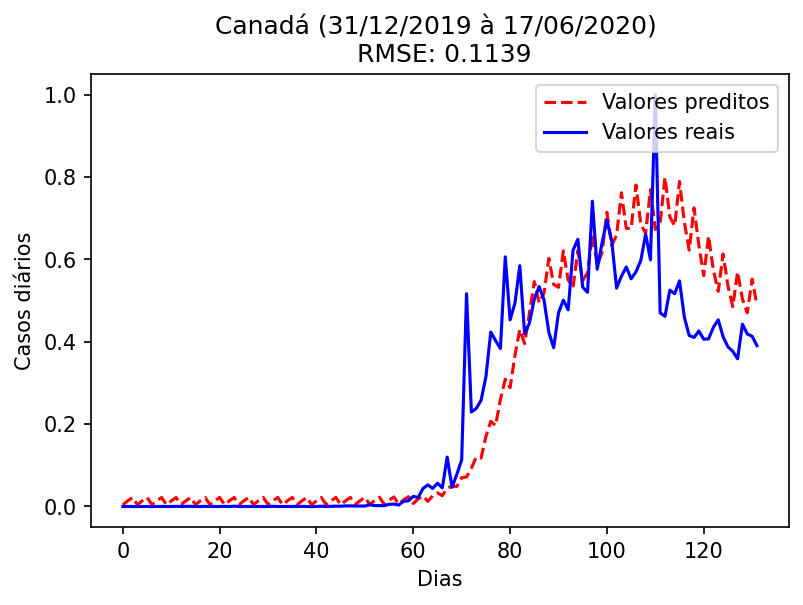

<Figure size 432x288 with 0 Axes>

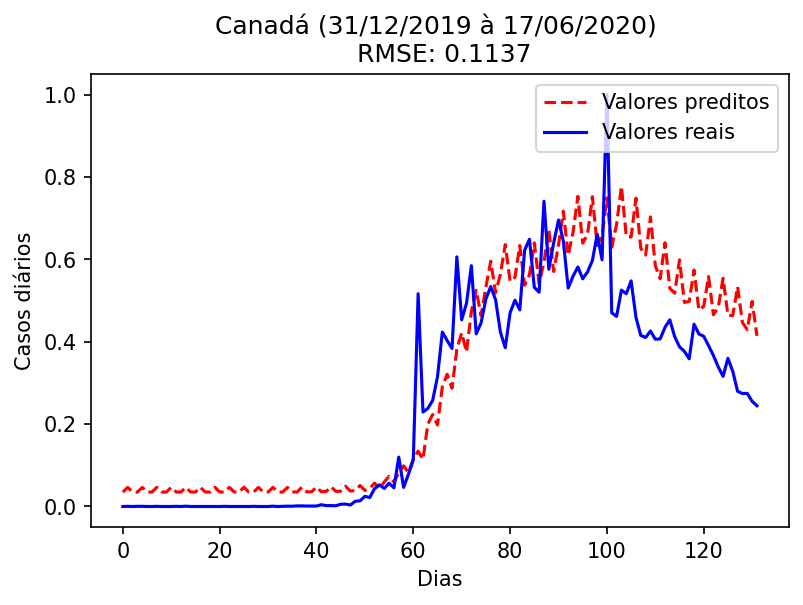

<Figure size 432x288 with 0 Axes>

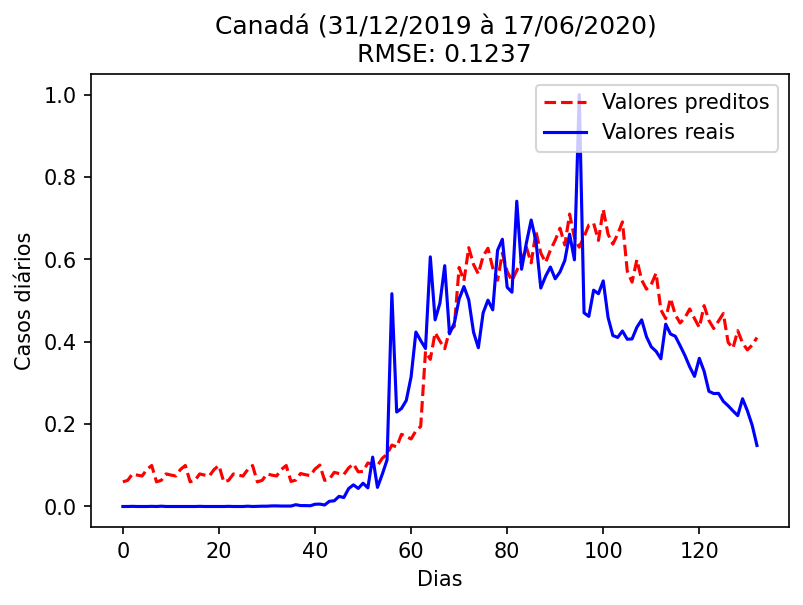

<Figure size 432x288 with 0 Axes>

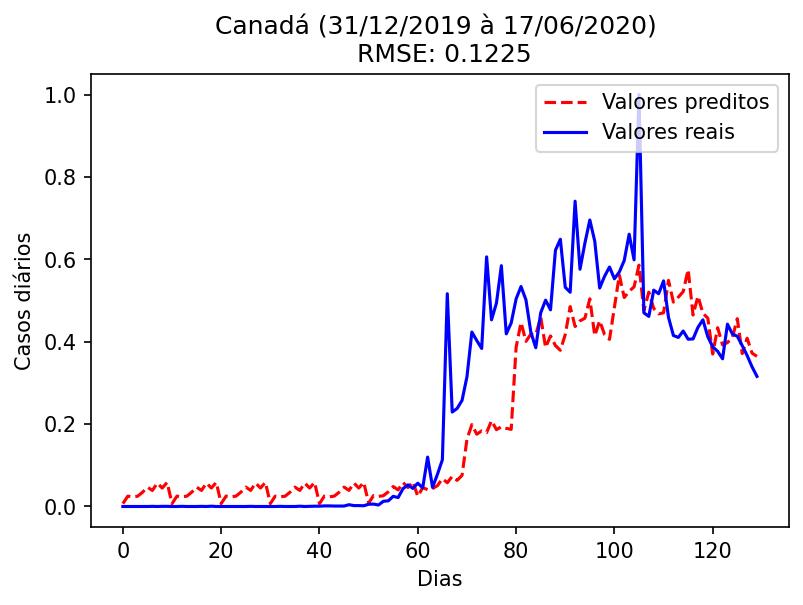

<Figure size 432x288 with 0 Axes>

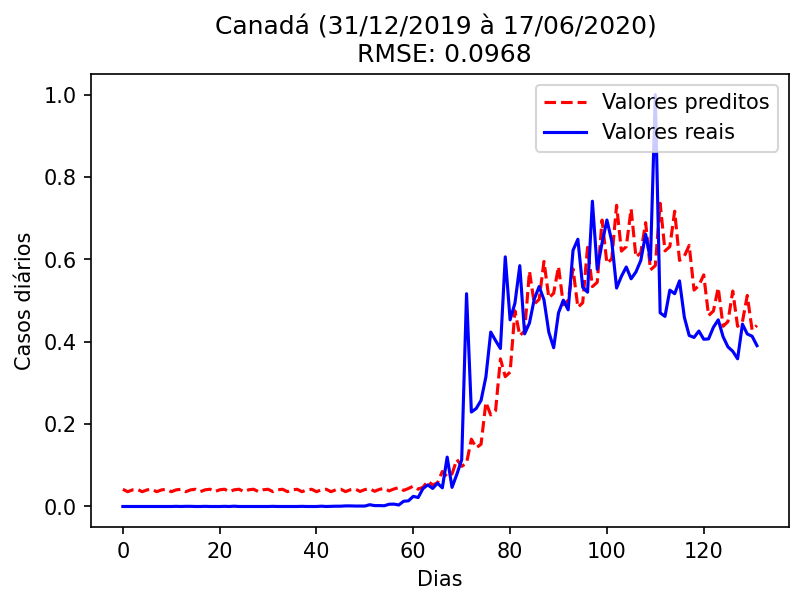

<Figure size 432x288 with 0 Axes>

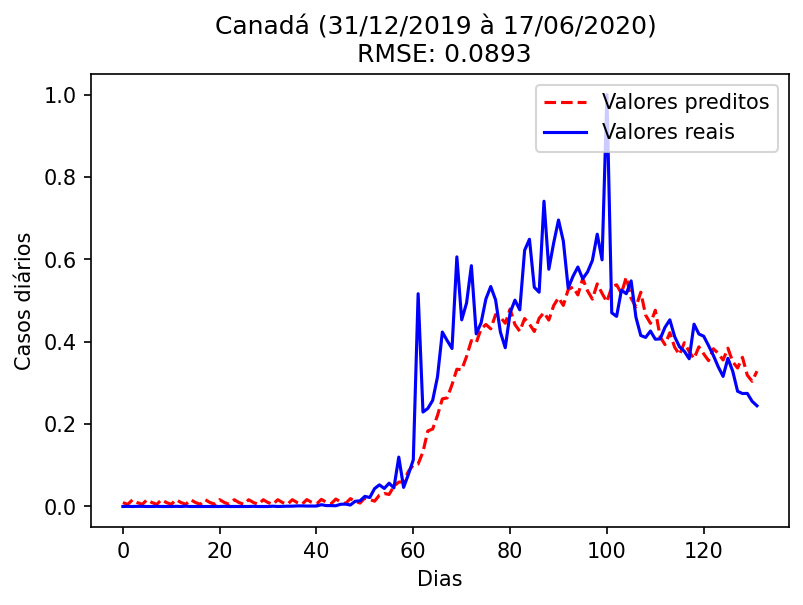

<Figure size 432x288 with 0 Axes>

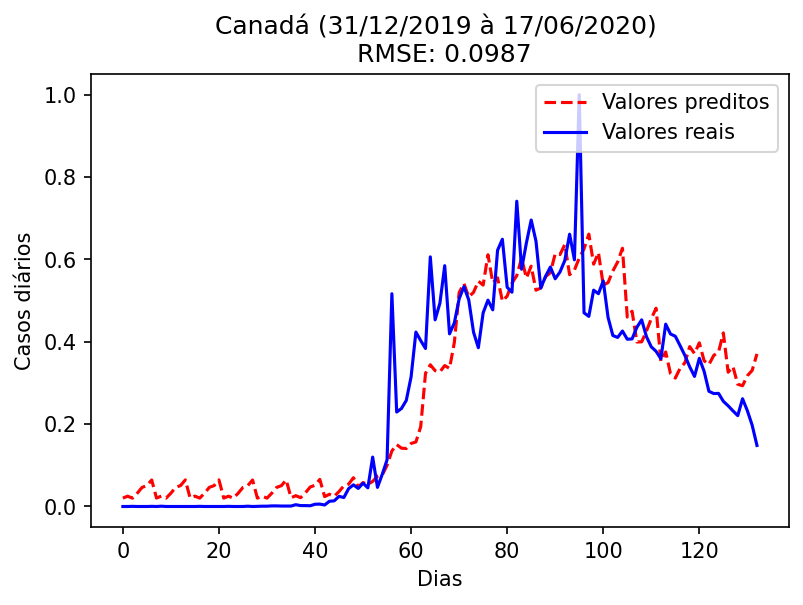

<Figure size 432x288 with 0 Axes>

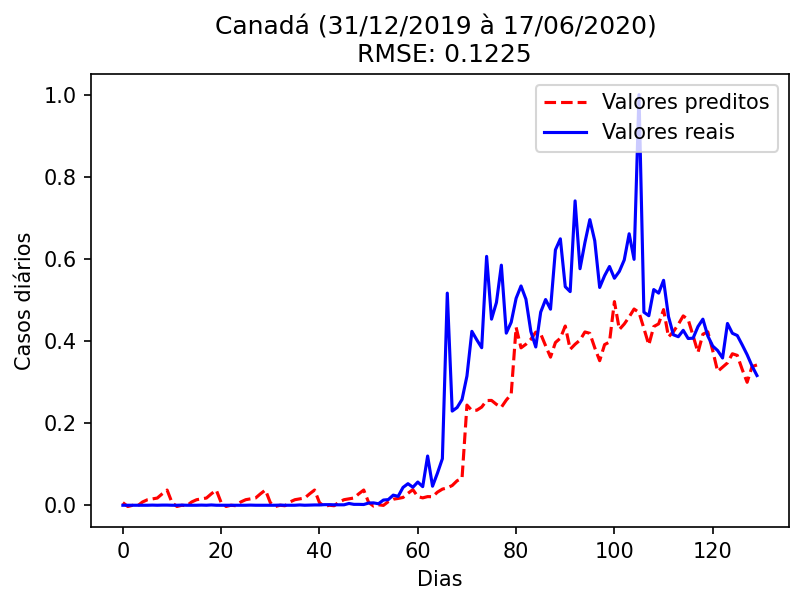

<Figure size 432x288 with 0 Axes>

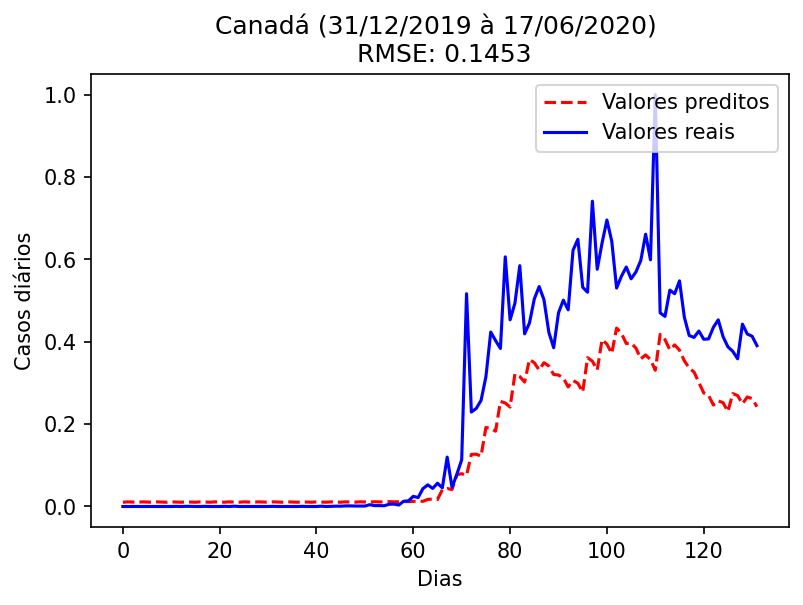

In [18]:
can_paramsrange = multiplas_execucoes("Canada", [(25, 3), (30, 7), (20, 10), (15, 3)],
                                      "Canadá (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", epochs_range = (2, 5))

**Cuba**

In [19]:
# cub_params = multiplas_execucoes("Cuba", [(10, 2)], "Cuba (I à F) \n {rmse}", epochs = 2)

**México**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: EpochsChange: O programa está sendo executado no modo de múltiplas épocas


Modelo_Mexico_v0
Epoch 1/2
135/135 [==============================] - 5s 36ms/step - loss: 0.0427
Epoch 2/2
135/135 [==============================] - 4s 33ms/step - loss: 0.0107
Modelo_Mexico_v1
Epoch 1/2
126/126 [==============================] - 5s 41ms/step - loss: 0.0693
Epoch 2/2
126/126 [==============================] - 5s 38ms/step - loss: 2.3545
entrou condi
Modelo_Mexico_v2
Epoch 1/2
133/133 [==============================] - 4s 31ms/step - loss: 0.0403
Epoch 2/2
133/133 [==============================] - 4s 28ms/step - loss: 0.0046
Modelo_Mexico_v3
Epoch 1/2
145/145 [==============================] - 3s 24ms/step - loss: 0.0321
Epoch 2/2
145/145 [==============================] - 3s 20ms/step - loss: 0.0052
Modelo_Mexico_v0
Epoch 1/3
135/135 [==============================] - 5s 36ms/step - loss: 0.0185
Epoch 2/3
135/135 [==============================] - 4s 32ms/step - loss: 0.0057
Epoch 3/3
135/135 [==============================] - 4s 33ms/step - loss: 0.0119
Modelo_Mexi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Modelo_Mexico_v3
Epoch 1/4
145/145 [==============================] - 3s 24ms/step - loss: 0.0280
Epoch 2/4
145/145 [==============================] - 3s 21ms/step - loss: 0.0046
Epoch 3/4
145/145 [==============================] - 3s 21ms/step - loss: 0.0041
Epoch 4/4
145/145 [==============================] - 3s 21ms/step - loss: 0.0058


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

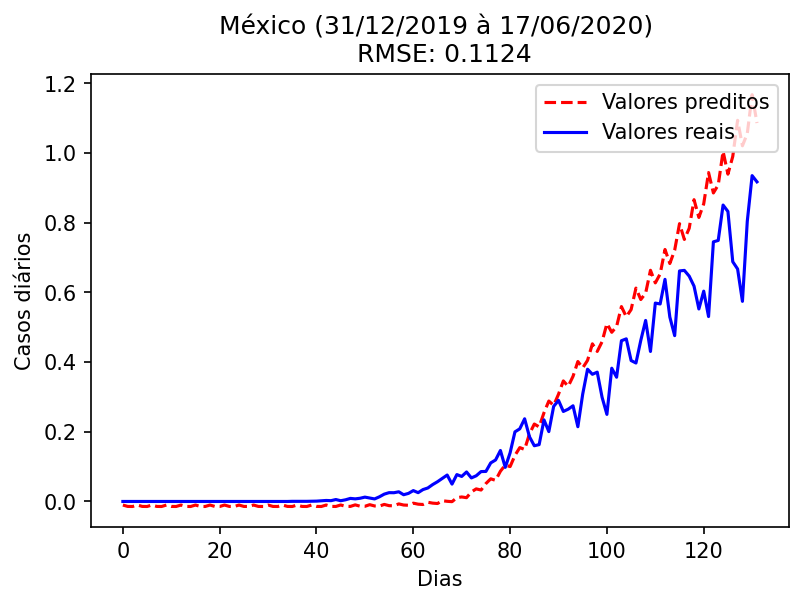

<Figure size 432x288 with 0 Axes>

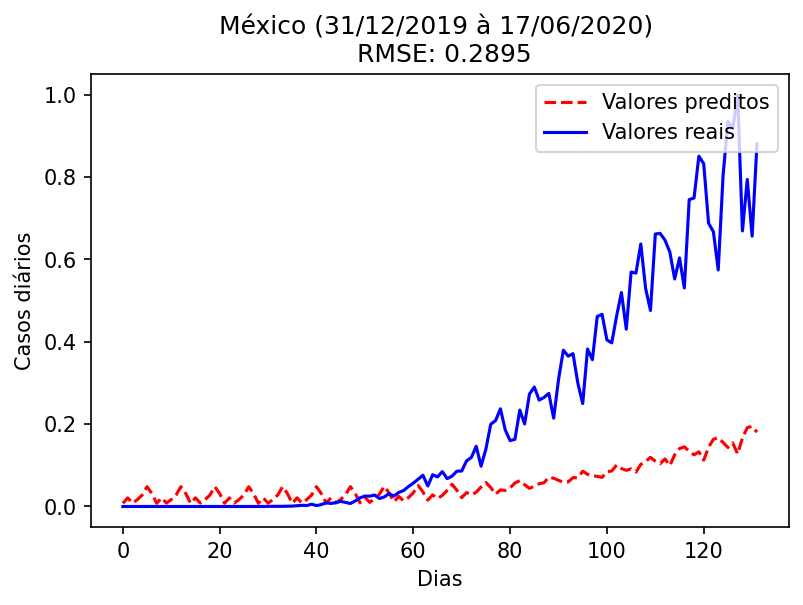

<Figure size 432x288 with 0 Axes>

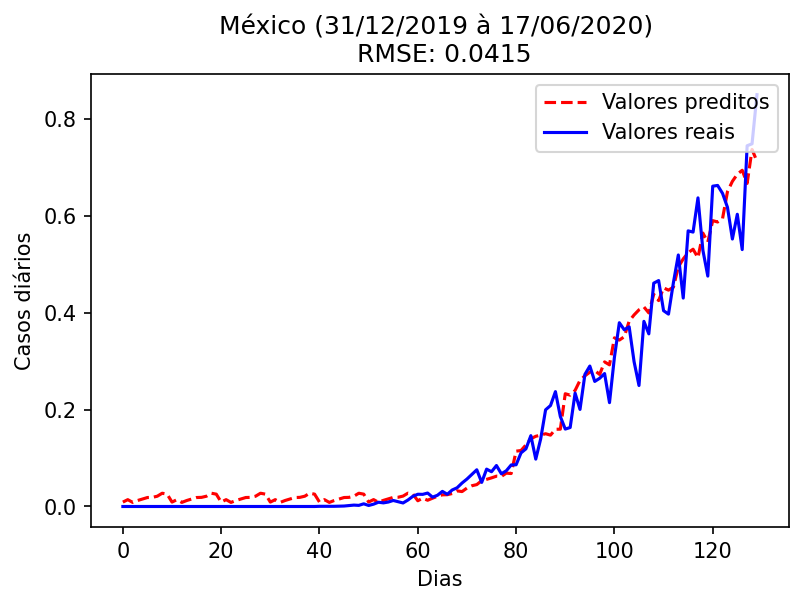

<Figure size 432x288 with 0 Axes>

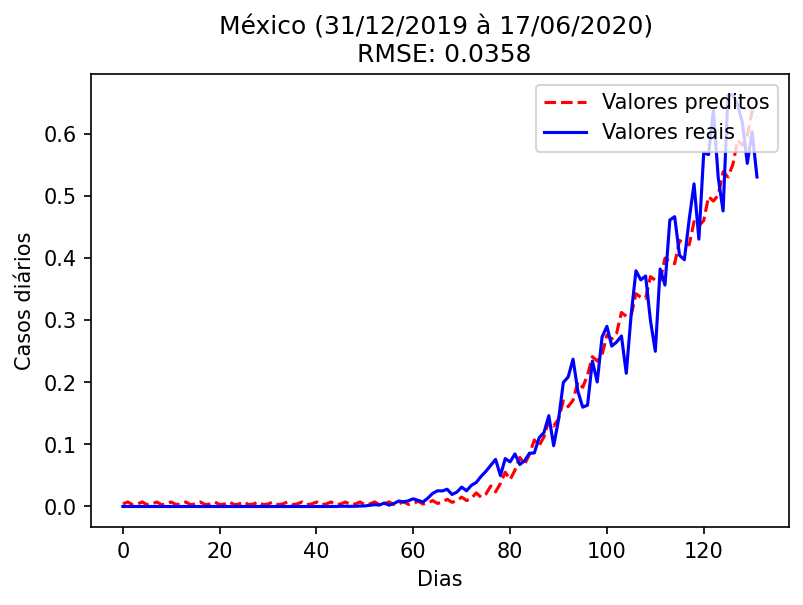

<Figure size 432x288 with 0 Axes>

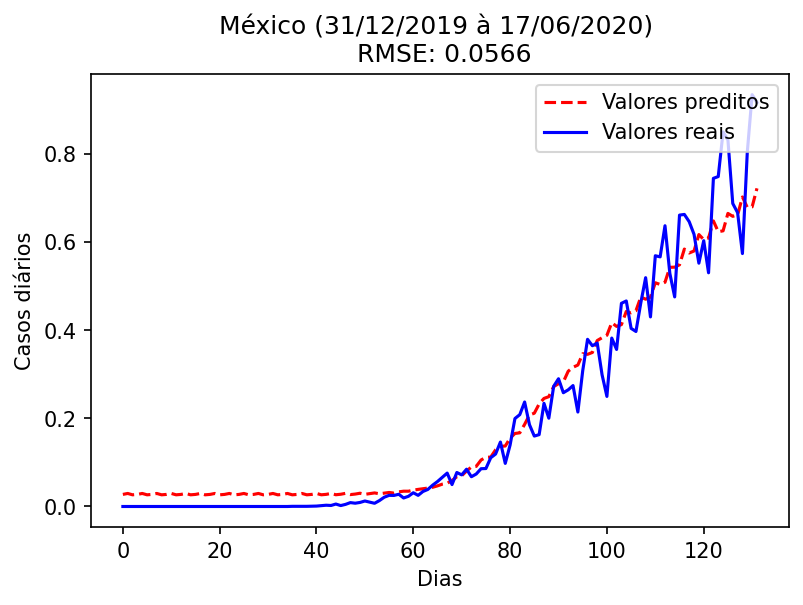

<Figure size 432x288 with 0 Axes>

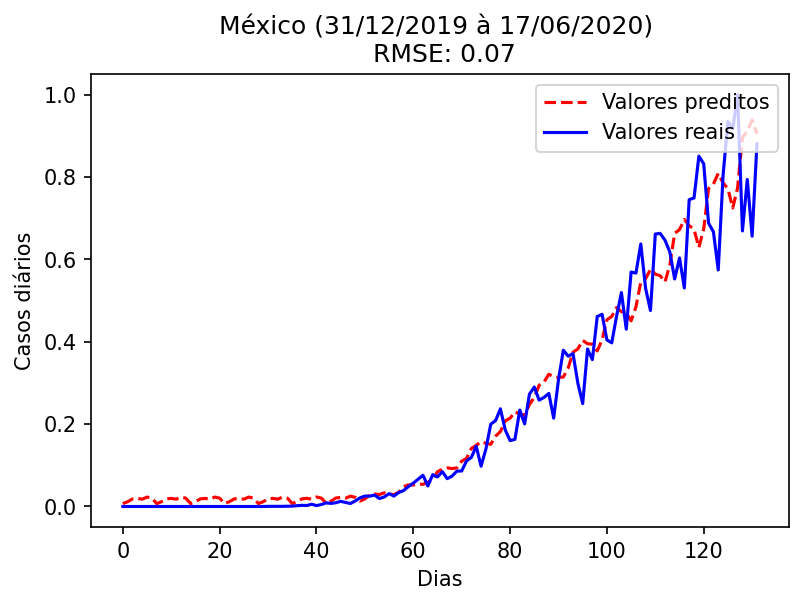

<Figure size 432x288 with 0 Axes>

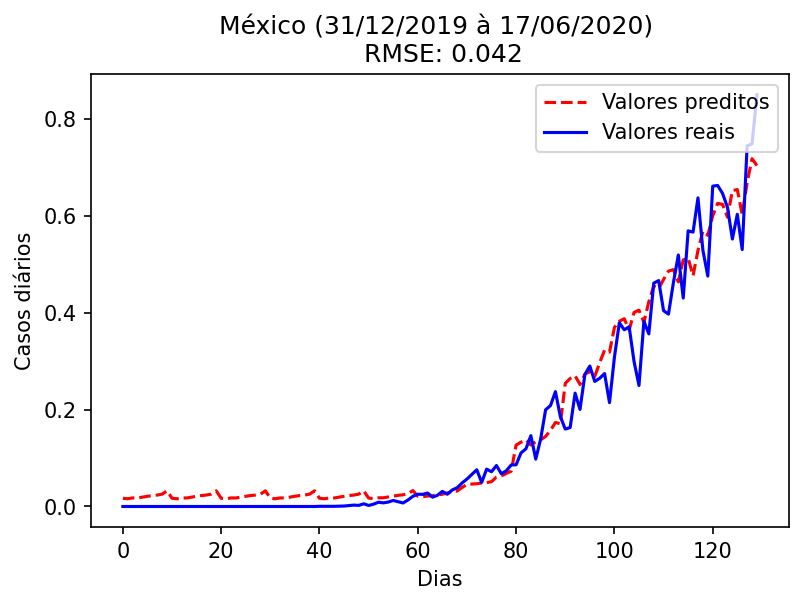

<Figure size 432x288 with 0 Axes>

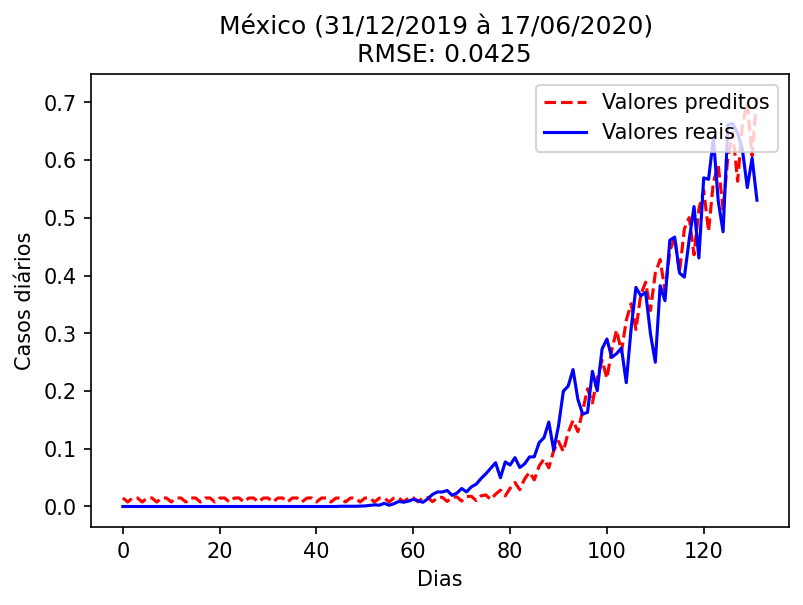

<Figure size 432x288 with 0 Axes>

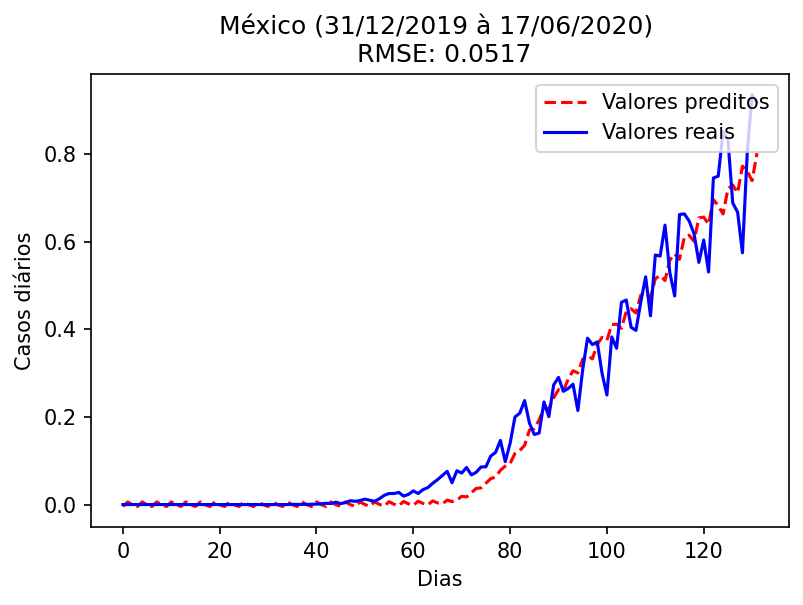

<Figure size 432x288 with 0 Axes>

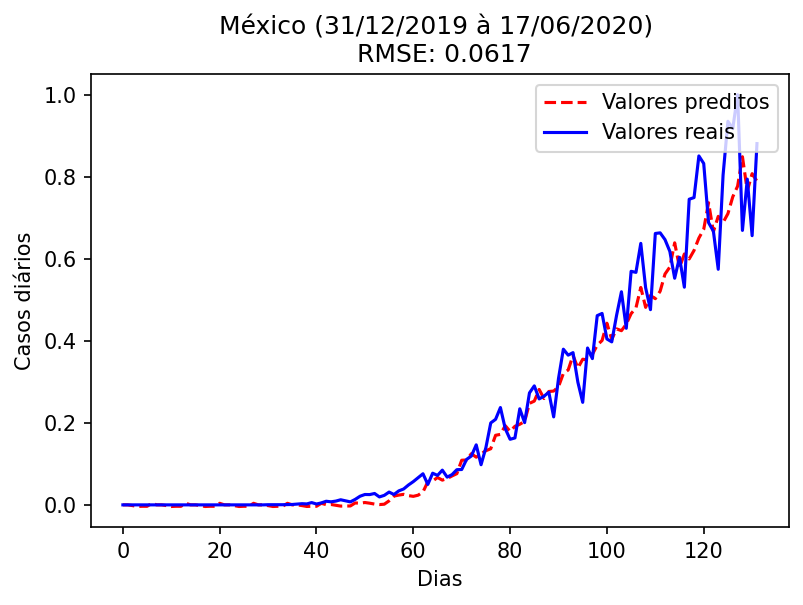

<Figure size 432x288 with 0 Axes>

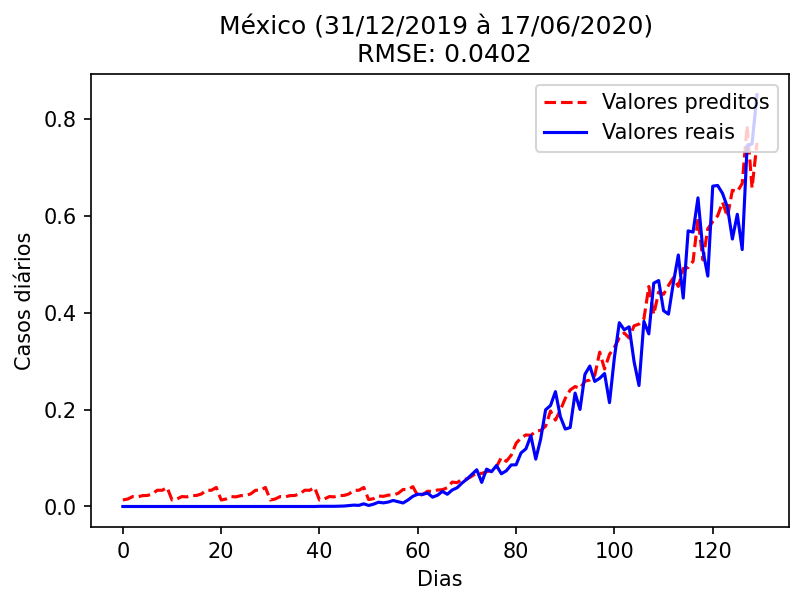

<Figure size 432x288 with 0 Axes>

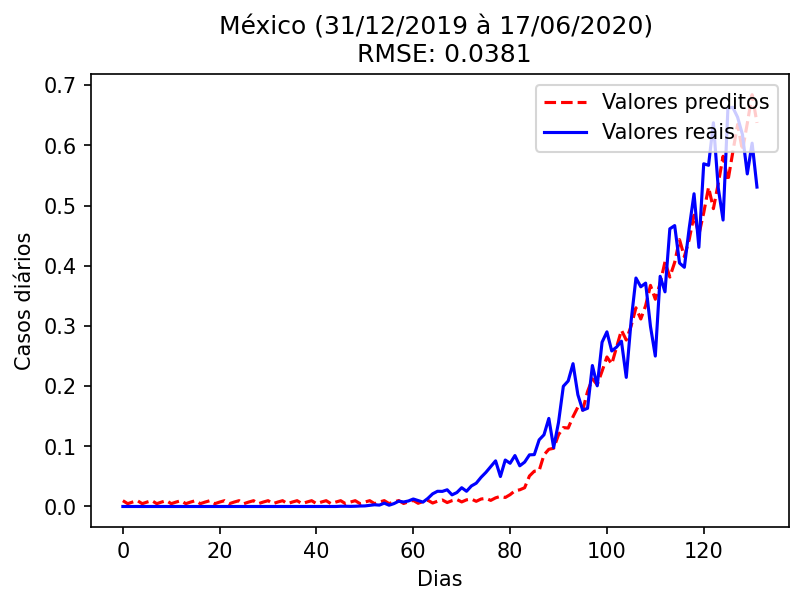

In [20]:
mex_paramsrange = multiplas_execucoes("Mexico", [(25, 3), (30, 7), (20, 10), (15, 3)], 
                                 "México (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", epochs_range = (2, 5))

**Rússia**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: EpochsChange: O programa está sendo executado no modo de múltiplas épocas


Modelo_Russia_v0
Epoch 1/2
143/143 [==============================] - 5s 36ms/step - loss: 0.1672
Epoch 2/2
143/143 [==============================] - 5s 32ms/step - loss: 0.0416
Modelo_Russia_v1
Epoch 1/2
134/134 [==============================] - 6s 42ms/step - loss: 0.0715
Epoch 2/2
134/134 [==============================] - 5s 38ms/step - loss: 0.0169
Modelo_Russia_v2
Epoch 1/2
141/141 [==============================] - 4s 31ms/step - loss: 0.2471
Epoch 2/2
141/141 [==============================] - 4s 28ms/step - loss: 0.0685
Modelo_Russia_v3
Epoch 1/2
153/153 [==============================] - 4s 24ms/step - loss: 0.0384
Epoch 2/2
153/153 [==============================] - 3s 20ms/step - loss: 0.0081
Modelo_Russia_v0
Epoch 1/3
143/143 [==============================] - 5s 35ms/step - loss: 0.0989
Epoch 2/3
143/143 [==============================] - 5s 32ms/step - loss: 0.5488
Epoch 3/3
143/143 [==============================] - 5s 34ms/step - loss: 0.1082
Modelo_Russia_v1
Epoch 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Modelo_Russia_v3
Epoch 1/4
153/153 [==============================] - 4s 25ms/step - loss: 0.1018
Epoch 2/4
153/153 [==============================] - 3s 21ms/step - loss: 0.0089
Epoch 3/4
153/153 [==============================] - 3s 21ms/step - loss: 0.0078
Epoch 4/4
153/153 [==============================] - 3s 21ms/step - loss: 0.0055


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

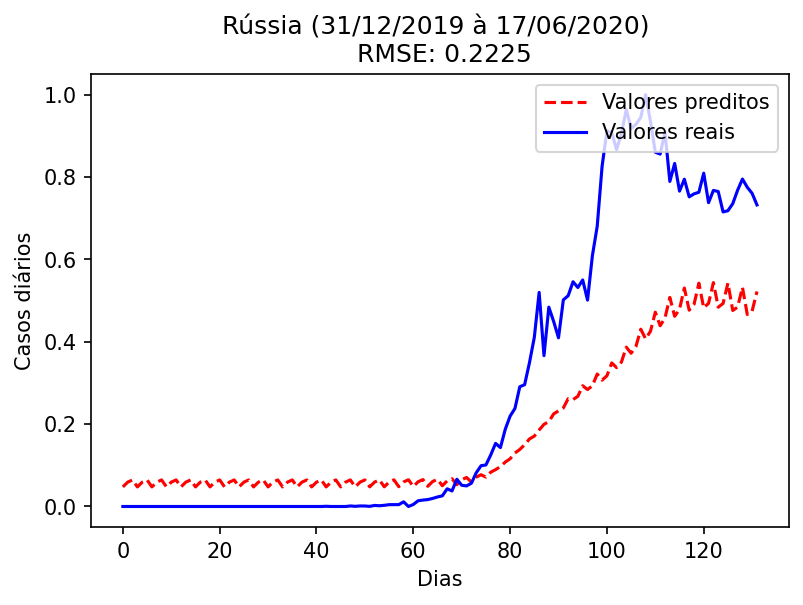

<Figure size 432x288 with 0 Axes>

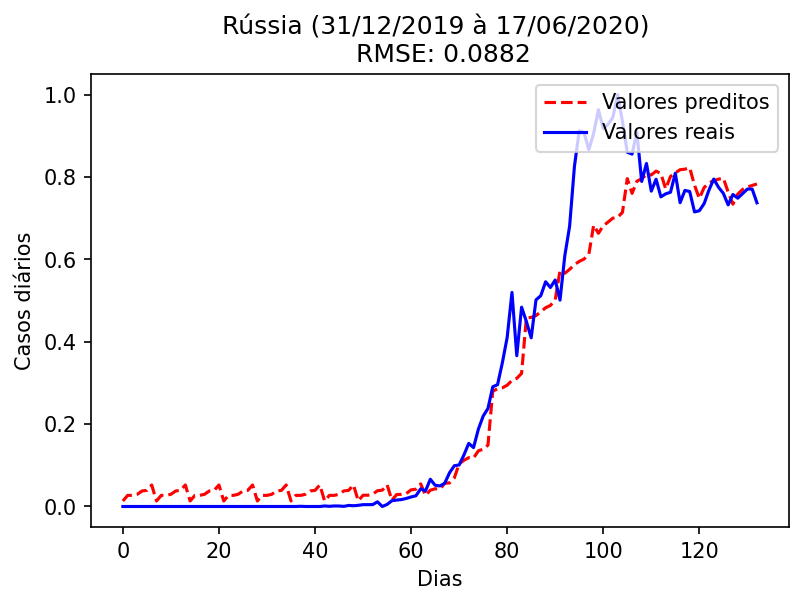

<Figure size 432x288 with 0 Axes>

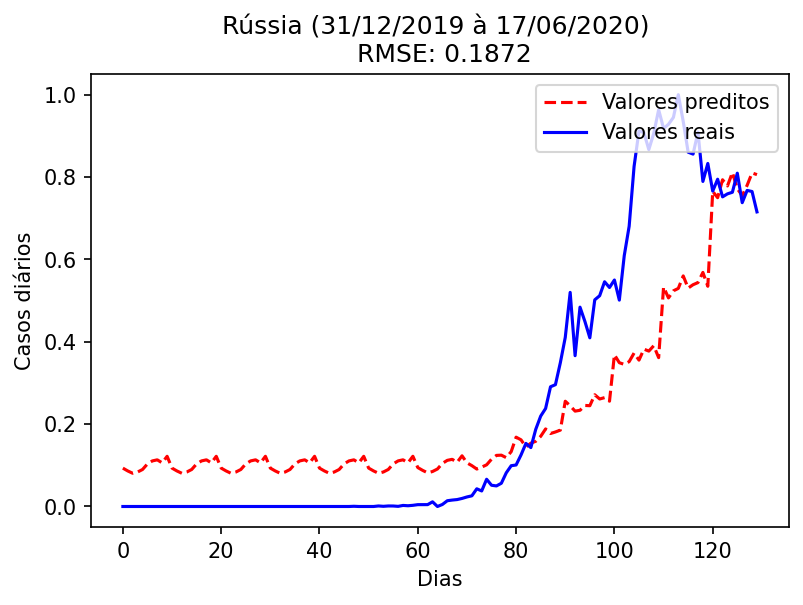

<Figure size 432x288 with 0 Axes>

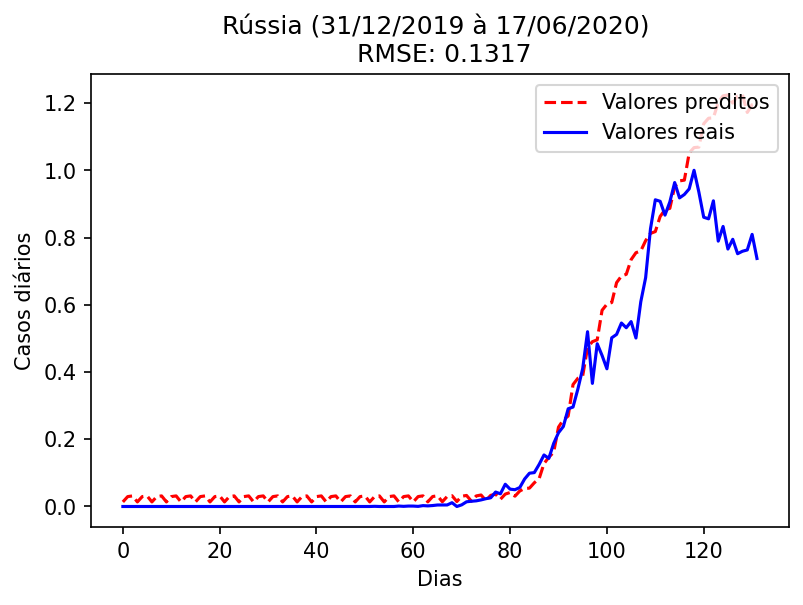

<Figure size 432x288 with 0 Axes>

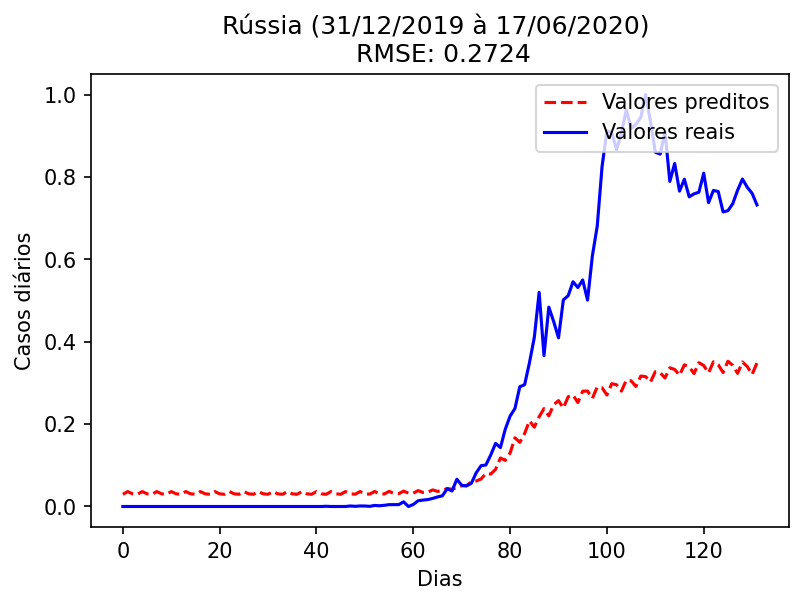

<Figure size 432x288 with 0 Axes>

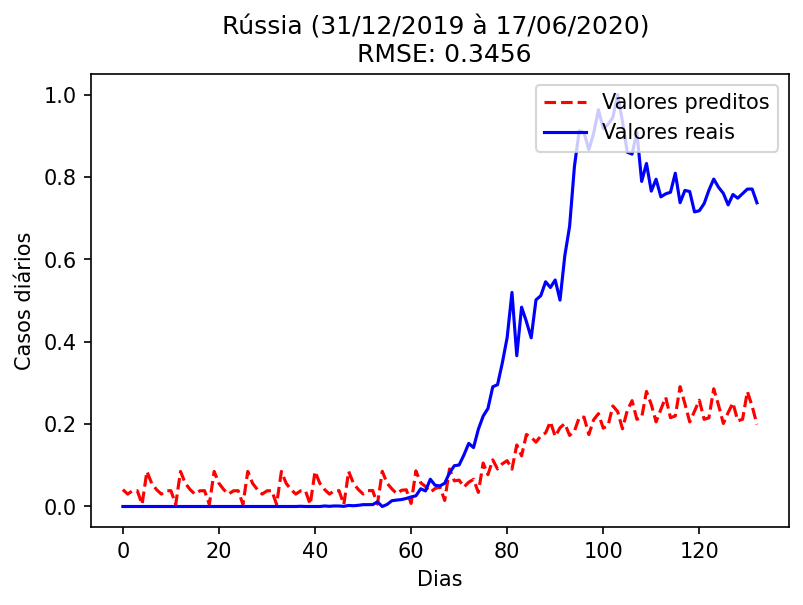

<Figure size 432x288 with 0 Axes>

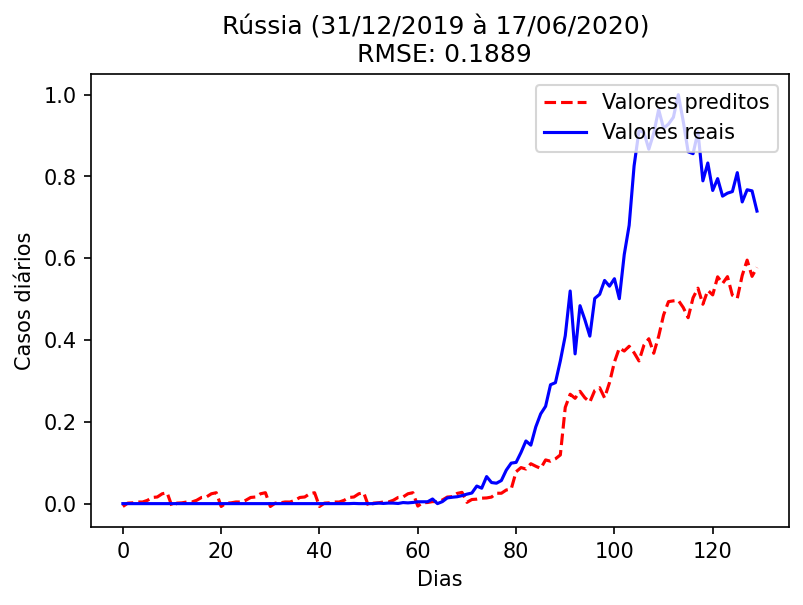

<Figure size 432x288 with 0 Axes>

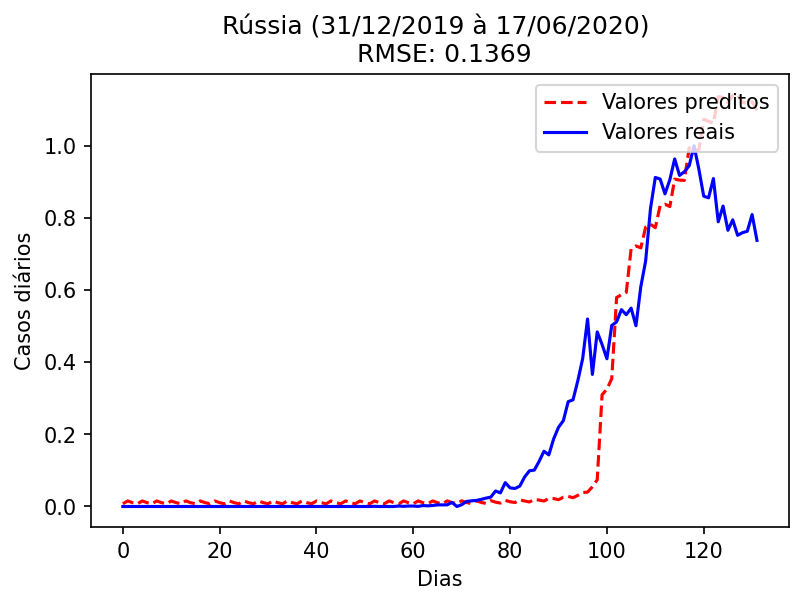

<Figure size 432x288 with 0 Axes>

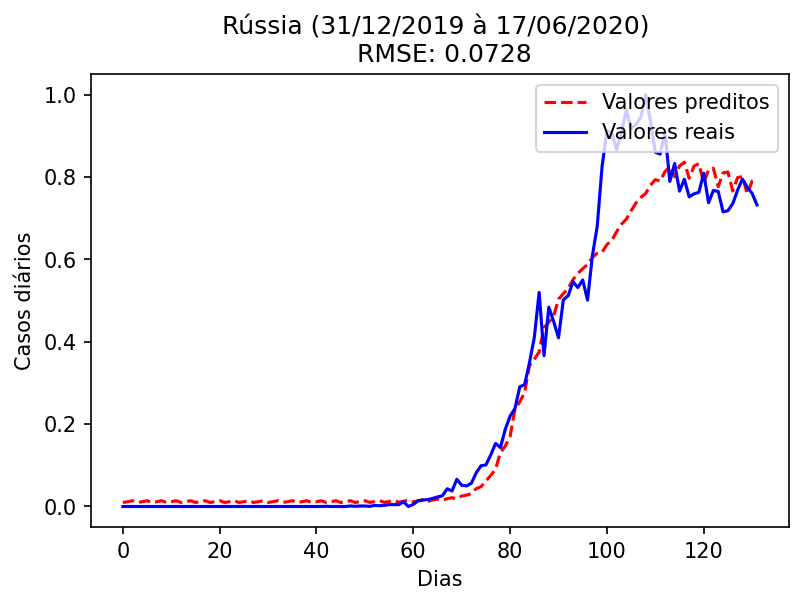

<Figure size 432x288 with 0 Axes>

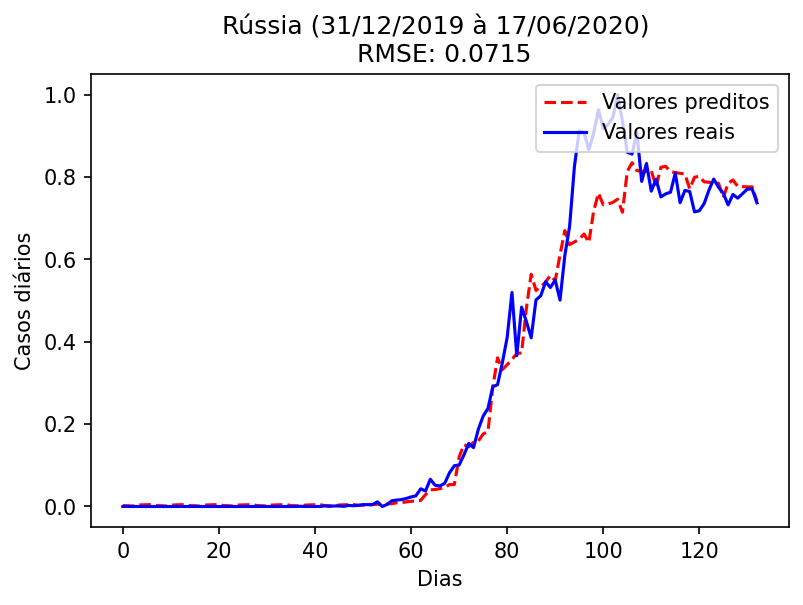

<Figure size 432x288 with 0 Axes>

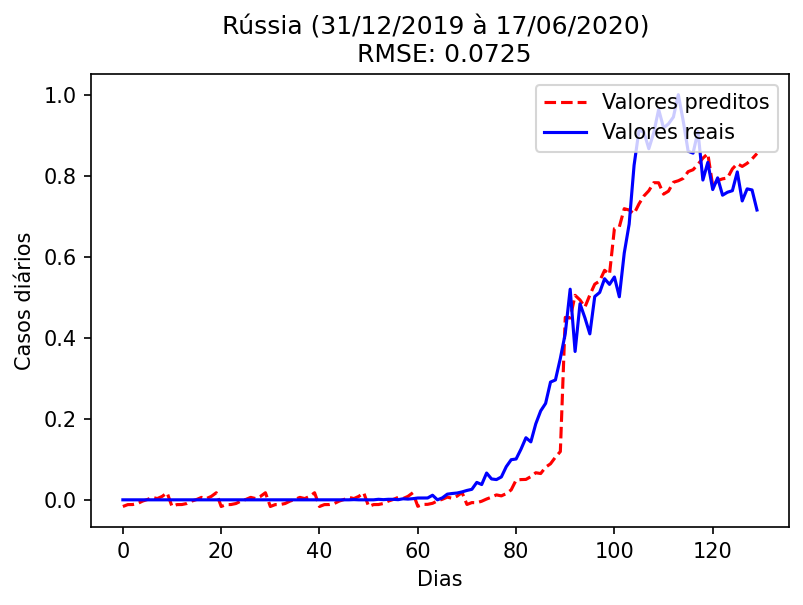

<Figure size 432x288 with 0 Axes>

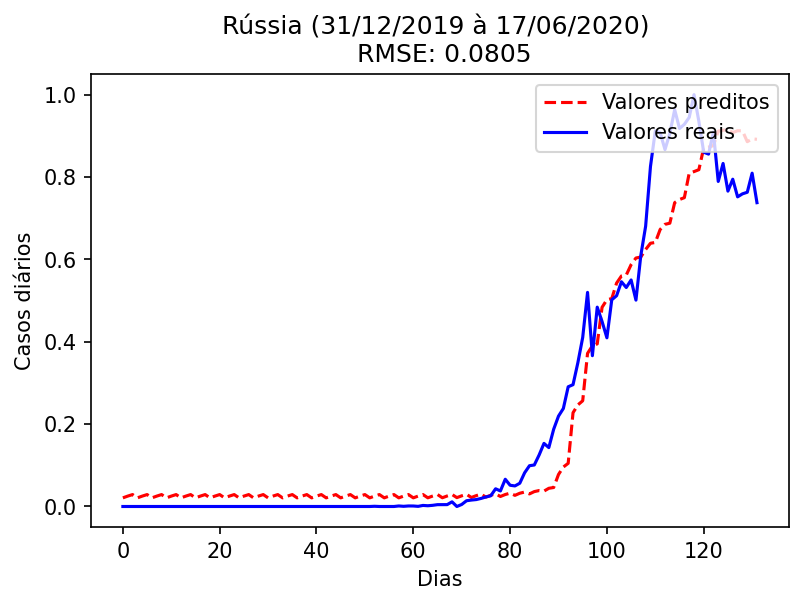

In [21]:
rus_paramsrange = multiplas_execucoes("Russia", [(25, 3), (30, 7), (20, 10), (15, 3)], 
                                 "Rússia (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", epochs_range = (2, 5))

**Brasil**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: EpochsChange: O programa está sendo executado no modo de múltiplas épocas


Modelo_Brazil_v0
Epoch 1/2
143/143 [==============================] - 5s 35ms/step - loss: 0.0374
Epoch 2/2
143/143 [==============================] - 5s 32ms/step - loss: 0.0179
Modelo_Brazil_v1
Epoch 1/2
134/134 [==============================] - 6s 42ms/step - loss: 0.0412
Epoch 2/2
134/134 [==============================] - 5s 37ms/step - loss: 0.0247
Modelo_Brazil_v2
Epoch 1/2
141/141 [==============================] - 4s 31ms/step - loss: 0.0780
Epoch 2/2
141/141 [==============================] - 4s 27ms/step - loss: 0.0426
Modelo_Brazil_v3
Epoch 1/2
153/153 [==============================] - 3s 23ms/step - loss: 0.0309
Epoch 2/2
153/153 [==============================] - 3s 21ms/step - loss: 0.0128
Modelo_Brazil_v0
Epoch 1/3
143/143 [==============================] - 5s 35ms/step - loss: 0.0396
Epoch 2/3
143/143 [==============================] - 4s 31ms/step - loss: 0.0351
Epoch 3/3
143/143 [==============================] - 5s 32ms/step - loss: 0.0133
Modelo_Brazil_v1
Epoch 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Modelo_Brazil_v3
Epoch 1/4
153/153 [==============================] - 4s 24ms/step - loss: 0.0292
Epoch 2/4
153/153 [==============================] - 3s 21ms/step - loss: 0.0105
Epoch 3/4
153/153 [==============================] - 3s 21ms/step - loss: 0.0093
Epoch 4/4
153/153 [==============================] - 3s 20ms/step - loss: 0.0091


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

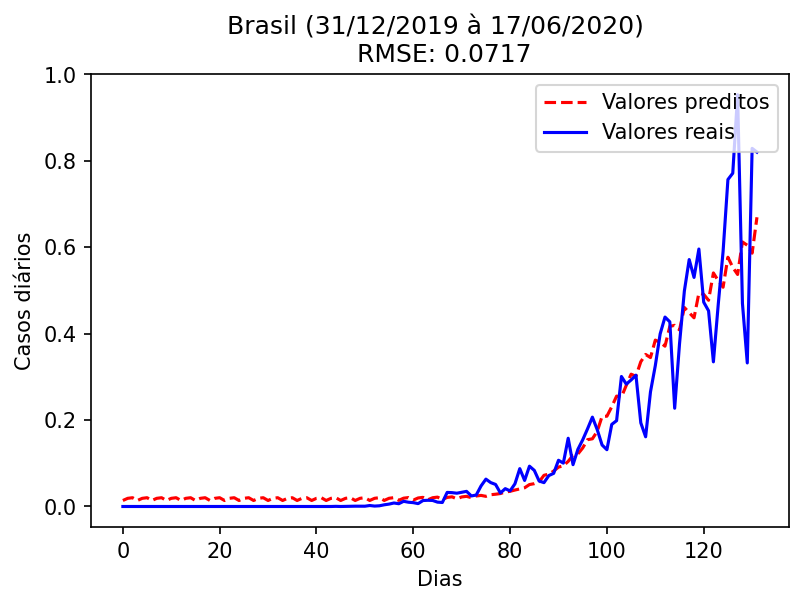

<Figure size 432x288 with 0 Axes>

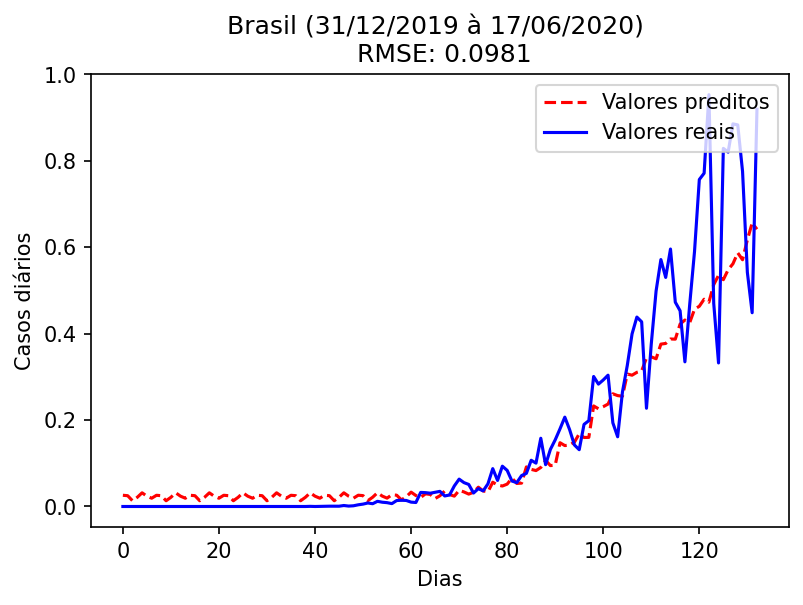

<Figure size 432x288 with 0 Axes>

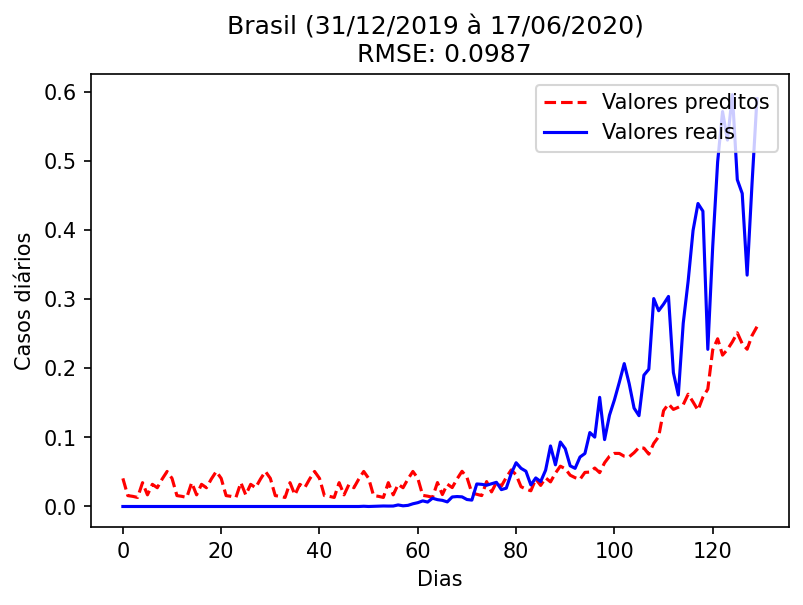

<Figure size 432x288 with 0 Axes>

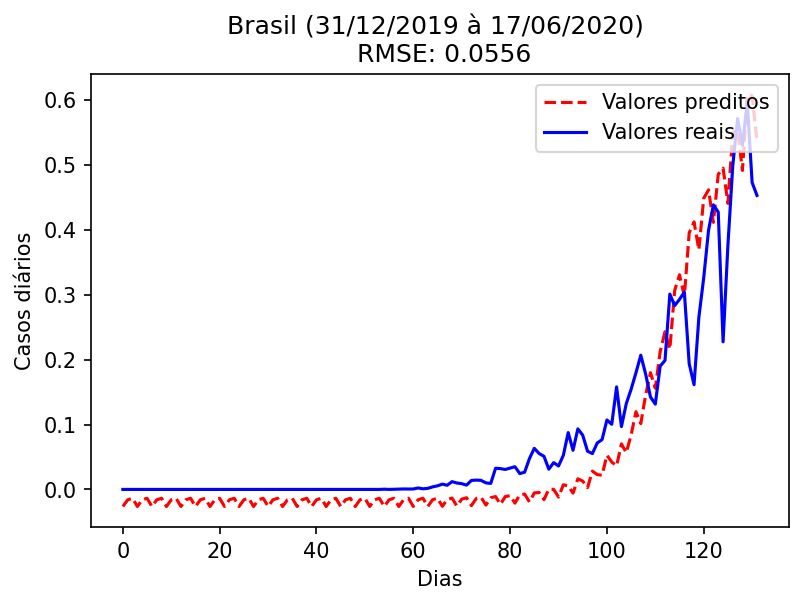

<Figure size 432x288 with 0 Axes>

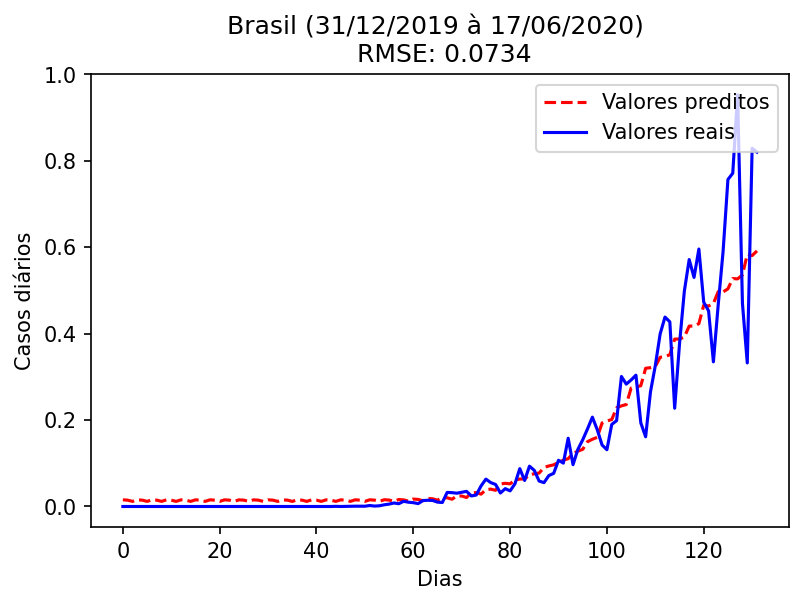

<Figure size 432x288 with 0 Axes>

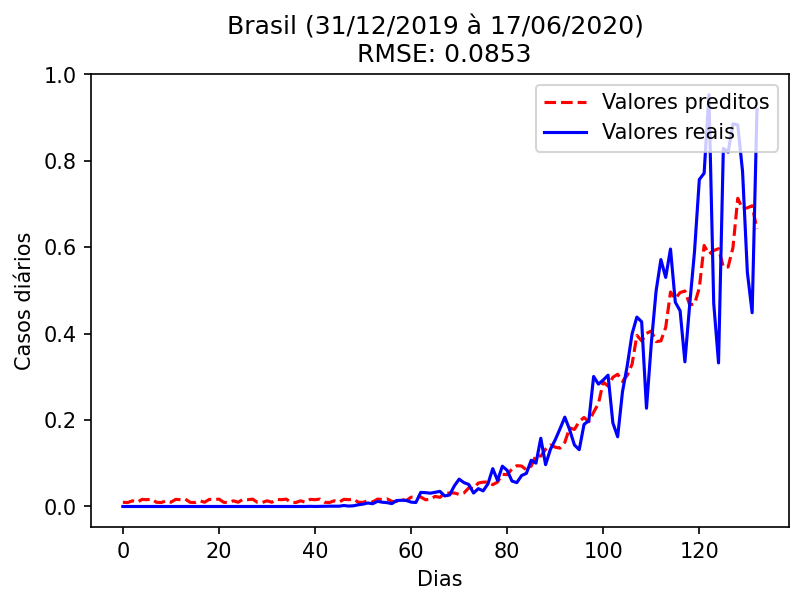

<Figure size 432x288 with 0 Axes>

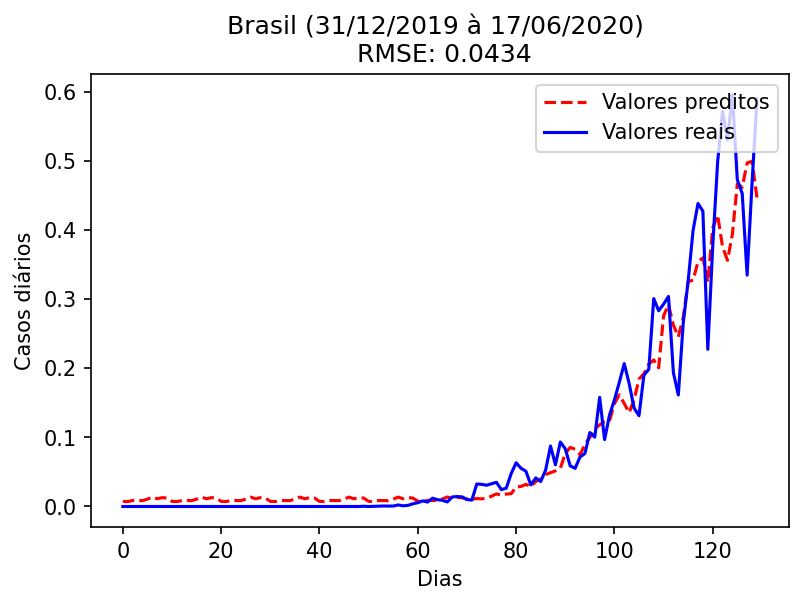

<Figure size 432x288 with 0 Axes>

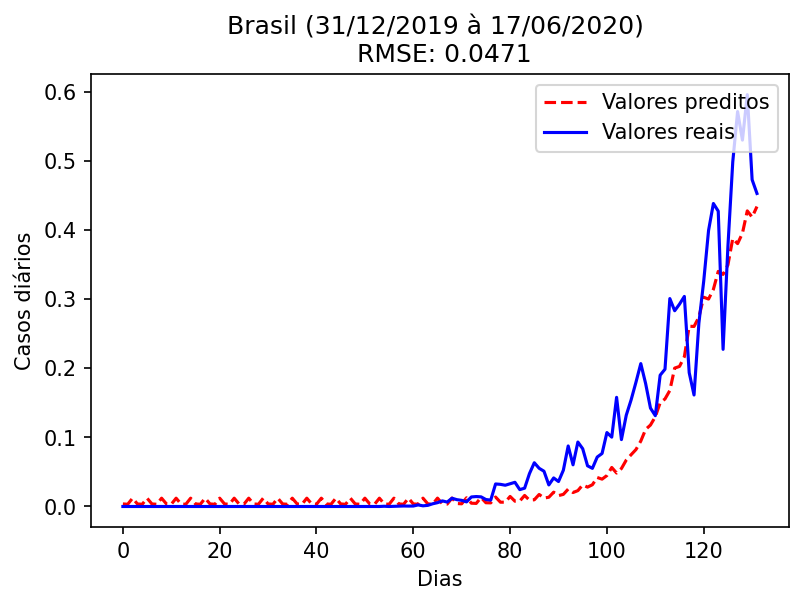

<Figure size 432x288 with 0 Axes>

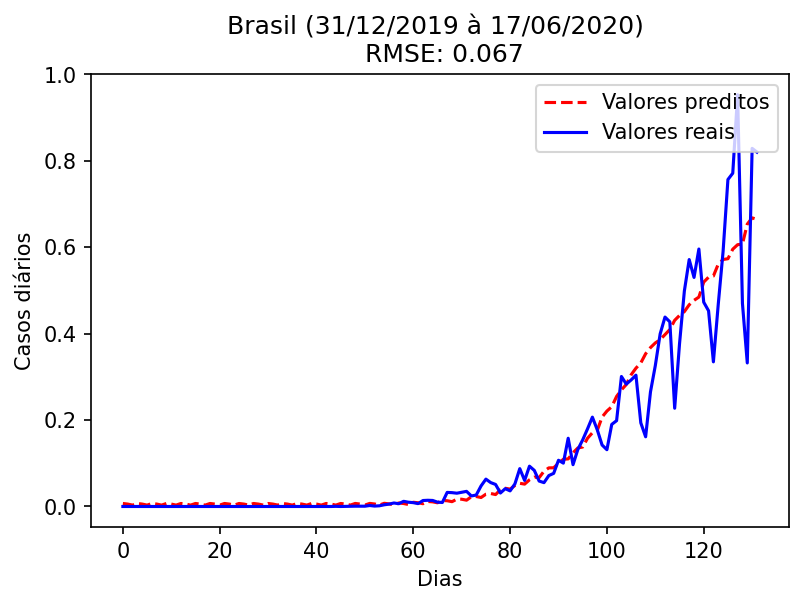

<Figure size 432x288 with 0 Axes>

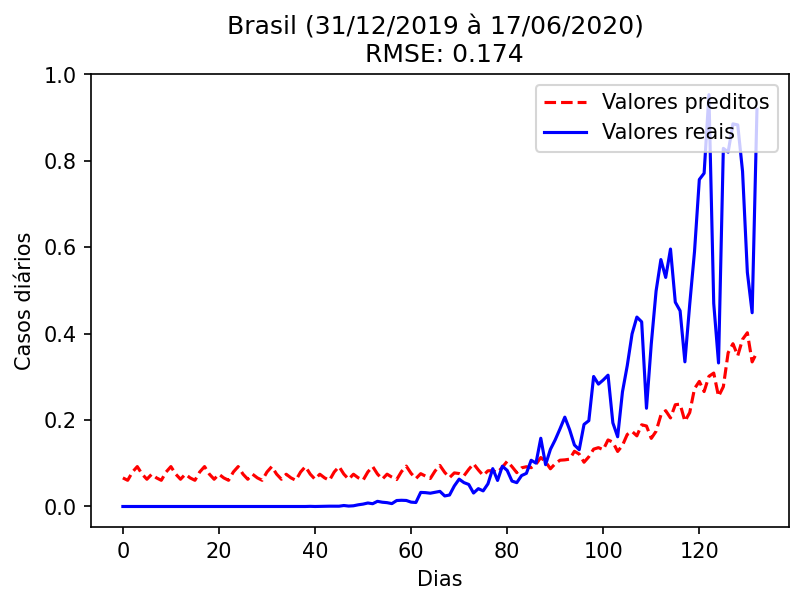

<Figure size 432x288 with 0 Axes>

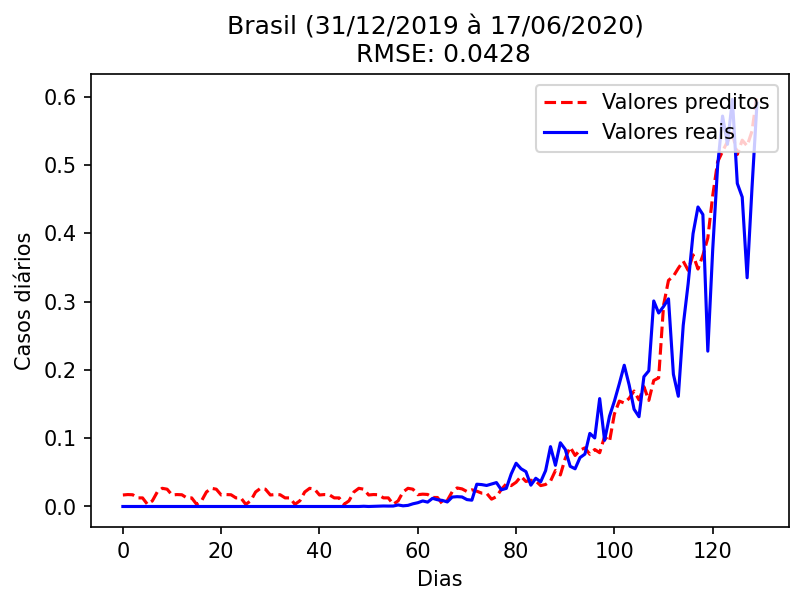

<Figure size 432x288 with 0 Axes>

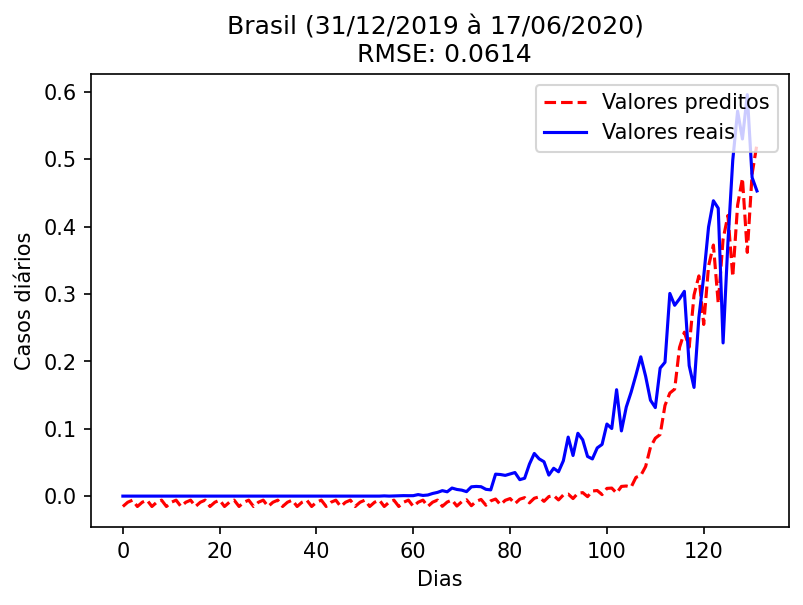

In [22]:
bras_paramsrange = multiplas_execucoes("Brazil", [(25, 3), (30, 7), (20, 10), (15, 3)], 
                                  "Brasil (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", epochs_range = (2, 5))

In [29]:
bras_paramsrange.head(8)

nome_modelo versao  entradas      rmse  epoch
0  Modelo_Brazil_v0     v0   (25, 3)  0.071749      2
1  Modelo_Brazil_v1     v1   (30, 7)  0.098075      2
2  Modelo_Brazil_v2     v2  (20, 10)  0.098660      2
3  Modelo_Brazil_v3     v3   (15, 3)  0.055627      2
0  Modelo_Brazil_v0     v0   (25, 3)  0.073410      3
1  Modelo_Brazil_v1     v1   (30, 7)  0.085290      3
2  Modelo_Brazil_v2     v2  (20, 10)  0.043352      3
3  Modelo_Brazil_v3     v3   (15, 3)  0.047128      3